In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import equinox as eqx
import optax
import numpy as np
from pyscf import dft, scf, gto, cc
from pyscfad import dft as dft_ad
from pyscfad import gto as gto_ad
from functools import partial
import pylibxc
import pyscfad.dft as dftad
from jax import custom_jvp
jax.config.update("jax_enable_x64", True) #Enables 64 bit precision


from xcquinox import net
from xcquinox.loss import compute_loss_mae
from xcquinox.train import Pretrainer
from xcquinox.utils import gen_grid_s, PBE_Fx, PBE_Fc, calculate_stats, lda_x, pw92c_unpolarized

/home/ICN2/snavarro/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


# Pre-training PBE Networks

In [2]:
#network structure
pbe_fx = net.GGA_FxNet_s(depth=3, nodes=16, seed=92017)
pbe_fc = net.GGA_FcNet_s(depth=3, nodes=16, seed=92017)

In [3]:
#sigma-based networks
spbe_fx = net.GGA_FxNet_sigma(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)
spbe_fc = net.GGA_FcNet_sigma(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)

In [4]:
#training and validation values
inds, vals, tflats, vflats = gen_grid_s(npts = 1e5)
train_inds, val_inds = inds
rv, grv, sv = vals
trf, tgrf, tsf = tflats
vrf, vgrf, vsf = vflats
#training and validation values for SIGMA
sinds, svals, stflats, svflats = gen_grid_s(npts = 1e5, sigma=True)
strain_inds, sval_inds = sinds
srv, sgrv, ssv = svals
strf, stgrf, stsf = stflats
svrf, svgrf, svsf = svflats

shapes- r/gr/s: (315,)/(315,)/(315,)
shapes- r/gr/s: (315,)/(315,)/(315,)


In [5]:
315**2, 0.8*315**2, 0.2*315**2

(99225, 79380.0, 19845.0)

In [6]:
train_inds, val_inds, strain_inds, sval_inds

(array([ 66, 313, 221, 275,  14, 310, 180, 165,  27, 225, 179, 132,  58,
        161,  35, 284,  21, 119, 229,  93, 257,  92, 176, 301, 308, 163,
         60, 297, 167, 208, 236, 187, 147, 237, 261, 197,  54,  99, 302,
        171, 259, 246, 295, 233,   1, 129,  64,  67, 252, 224, 256, 130,
        207, 299, 160, 191,  98, 203,  73, 182, 181, 103, 292,  23,  34,
        234,  10,   9, 298, 212, 113,   7, 290,  25, 110, 131,  96, 186,
         40, 122, 291, 286, 100, 107,  95,  65,  75, 138, 140, 210,  36,
         89,  47, 250, 108, 312, 231, 139,  62,  15,  28, 296,  79,  59,
        133, 293, 185, 251, 314,  33, 240, 195,   8,  45, 204, 311, 175,
        274, 153,  91,  84,  85, 159, 137, 166, 276, 104, 192,  81,  49,
        193, 199, 222, 217, 190, 279, 105, 198, 121, 173, 143, 235, 155,
         12, 128, 305,  22,  38,  17,  26,  71,   6, 232, 282, 307,  82,
        244, 281, 215,  52,  87,  63, 188, 118, 219,  32, 243,  19, 184,
        280, 125,  74, 238, 169, 120, 111, 154, 177

In [7]:
train_inds.shape, val_inds.shape, strain_inds.shape, sval_inds.shape

((253,), (62,), (253,), (62,))

In [8]:
253**2, 62**2, 253**2 + 62**2, 

(64009, 3844, 67853)

In [9]:
ref_fx = PBE_Fx(trf, tgrf)
ref_fc = PBE_Fc(trf, tgrf)

sinputs = jnp.stack([trf, tsf], axis=1)
siginputs = jnp.stack([strf, stgrf], axis=1)
sval = jnp.stack([vrf, vsf], axis=1)
print(sval.shape, sinputs.shape)

(3844, 2) (64009, 2)


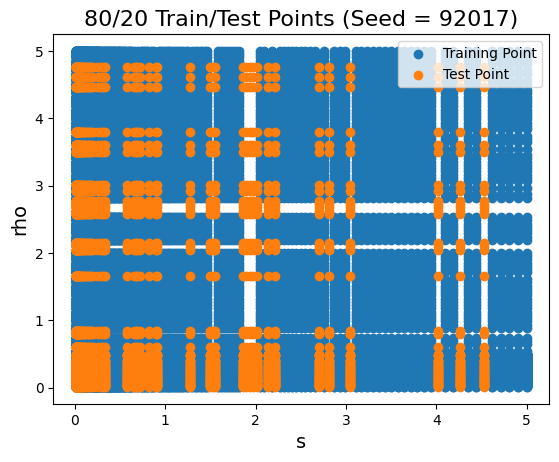

In [10]:
plt.scatter(trf, tsf, label='Training Point')
plt.scatter(vrf, vsf, label='Test Point')
plt.ylabel('rho', fontsize=14)
plt.xlabel('s', fontsize=14)
plt.title('80/20 Train/Test Points (Seed = 92017)', fontsize=16)
plt.legend()

In [11]:
#create optimizers
optimizer_fx = optax.chain(
    optax.adam(learning_rate=1e-4)
)
optimizer_fc = optax.chain(
    optax.adam(learning_rate=1e-3)
)

In [12]:
pt_pbe_fx = Pretrainer(model = pbe_fx, optim = optimizer_fx, inputs = sinputs, ref = ref_fx, loss = compute_loss_mae, steps = 2500)
pt_pbe_fc = Pretrainer(model = pbe_fc, optim = optimizer_fc, inputs = sinputs, ref = ref_fc, loss = compute_loss_mae, steps = 2500)

In [13]:
nmx, nlx = pt_pbe_fx()
nmc, nlc = pt_pbe_fc()

Epoch 0: Loss = 0.12663097651184216
Epoch 100: Loss = 0.09844872335327282
Epoch 200: Loss = 0.06325872688253247
Epoch 300: Loss = 0.02254397005582909
Epoch 400: Loss = 0.0035225629675758826
Epoch 500: Loss = 0.002974922958551256
Epoch 600: Loss = 0.0024582211538656125
Epoch 700: Loss = 0.0019585930070951446
Epoch 800: Loss = 0.0014636003892057607
Epoch 900: Loss = 0.0010763426445123394
Epoch 1000: Loss = 0.0008263259660462184
Epoch 1100: Loss = 0.0006261406368071129
Epoch 1200: Loss = 0.0003973597284336373
Epoch 1300: Loss = 0.00030264349786875697
Epoch 1400: Loss = 0.0002667792453816241
Epoch 1500: Loss = 0.0002406529836666981
Epoch 1600: Loss = 0.00021165557582128474
Epoch 1700: Loss = 0.00018650099396848047
Epoch 1800: Loss = 0.00016440836356620834
Epoch 1900: Loss = 0.00014549865120115434
Epoch 2000: Loss = 0.0001281042020596158
Epoch 2100: Loss = 0.00011246143438367815
Epoch 2200: Loss = 9.902745389103946e-05
Epoch 2300: Loss = 8.773345212590339e-05
Epoch 2400: Loss = 7.7296794904

In [14]:
#create optimizers
soptimizer_fx = optax.chain(
    optax.adam(learning_rate=1e-3)
)
soptimizer_fc = optax.chain(
    optax.adam(learning_rate=1e-3)
)
spt_pbe_fx = Pretrainer(model = spbe_fx, optim = soptimizer_fx, inputs = siginputs, ref = ref_fx, loss = compute_loss_mae, steps = 2500)
spt_pbe_fc = Pretrainer(model = spbe_fc, optim = soptimizer_fc, inputs = siginputs, ref = ref_fc, loss = compute_loss_mae, steps = 2500)

In [15]:
snmx, snlx = spt_pbe_fx()
snmc, snlc = spt_pbe_fc()

Epoch 0: Loss = 0.12663097651184216
Epoch 100: Loss = 0.001767185656495253
Epoch 200: Loss = 0.0003965925629766827
Epoch 300: Loss = 0.0002891233052268366
Epoch 400: Loss = 0.00016220979333160483
Epoch 500: Loss = 0.0004153561510694539
Epoch 600: Loss = 0.00030480704476934484
Epoch 700: Loss = 0.00017691502797182883
Epoch 800: Loss = 8.416372507587452e-05
Epoch 900: Loss = 0.00042248722558047816
Epoch 1000: Loss = 0.0001188910551579722
Epoch 1100: Loss = 7.404514466943702e-05
Epoch 1200: Loss = 0.0002812912746333294
Epoch 1300: Loss = 0.0005135179035251922
Epoch 1400: Loss = 0.00010445190975950438
Epoch 1500: Loss = 0.0003308283695002126
Epoch 1600: Loss = 7.51739172698043e-05
Epoch 1700: Loss = 0.0003138221200721593
Epoch 1800: Loss = 0.000709819492560341
Epoch 1900: Loss = 0.00042569768777568303
Epoch 2000: Loss = 0.0002733275062483645
Epoch 2100: Loss = 0.0003532146246426631
Epoch 2200: Loss = 0.0003858761748142734
Epoch 2300: Loss = 0.00021954711246018
Epoch 2400: Loss = 0.00039701

To demonstrate how critical the choice of training data is, see below.

shapes- r/gr/s: (315,)/(315,)/(315,)


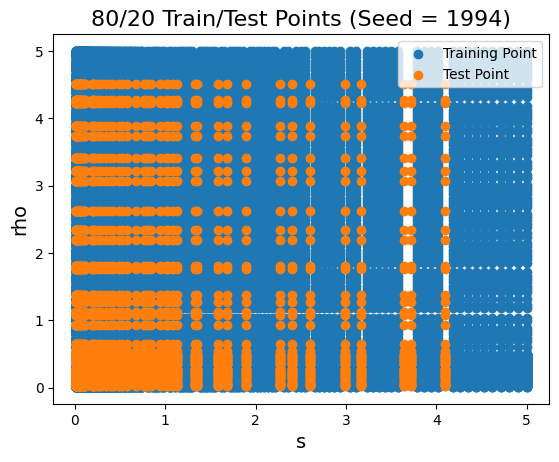

In [16]:
sinds2, svals2, stflats2, svflats2 = gen_grid_s(npts = 1e5, sigma=True, ranseed=1994)
strain_inds2, sval_inds2 = sinds2
srv2, sgrv2, ssv2 = svals2
strf2, stgrf2, stsf2 = stflats2
svrf2, svgrf2, svsf2 = svflats2

plt.scatter(strf2, stsf2, label='Training Point')
plt.scatter(svrf2, svsf2, label='Test Point')
plt.ylabel('rho', fontsize=14)
plt.xlabel('s', fontsize=14)
plt.title('80/20 Train/Test Points (Seed = 1994)', fontsize=16)
plt.legend()
siginputs2 = jnp.stack([strf2, stgrf2], axis=1)
soptimizer_fx2 = optax.chain(
    optax.adam(learning_rate=1e-3)
)
soptimizer_fc2 = optax.chain(
    optax.adam(learning_rate=1e-3)
)

spt_pbe_fx2 = Pretrainer(model = spbe_fx, optim = soptimizer_fx2, inputs = siginputs2, ref = ref_fx, loss = compute_loss_mae, steps = 2500)
spt_pbe_fc2 = Pretrainer(model = spbe_fc, optim = soptimizer_fc2, inputs = siginputs2, ref = ref_fc, loss = compute_loss_mae, steps = 2500)

In [17]:
snmx2, snlx2 = spt_pbe_fx2()
snmc2, snlc2 = spt_pbe_fc2()

Epoch 0: Loss = 0.15719585433885377
Epoch 100: Loss = 0.1471939219025453
Epoch 200: Loss = 0.1458719625419891
Epoch 300: Loss = 0.14467193818685717
Epoch 400: Loss = 0.14342436379506177
Epoch 500: Loss = 0.14251454587287823
Epoch 600: Loss = 0.1423987866810566
Epoch 700: Loss = 0.14235073217224817
Epoch 800: Loss = 0.14227861847362416
Epoch 900: Loss = 0.14231969585287318
Epoch 1000: Loss = 0.14215930456792247
Epoch 1100: Loss = 0.14204863084219513
Epoch 1200: Loss = 0.14191672629097896
Epoch 1300: Loss = 0.1417119547477478
Epoch 1400: Loss = 0.14153251009256557
Epoch 1500: Loss = 0.1414090403194653
Epoch 1600: Loss = 0.14131164223683348
Epoch 1700: Loss = 0.14124131090245168
Epoch 1800: Loss = 0.14119546078797912
Epoch 1900: Loss = 0.14117022289583864
Epoch 2000: Loss = 0.1411380059537259
Epoch 2100: Loss = 0.14112222670837968
Epoch 2200: Loss = 0.14107908493607355
Epoch 2300: Loss = 0.1410516310003443
Epoch 2400: Loss = 0.14104333479852973
Epoch 0: Loss = 0.3633249047965794
Epoch 100

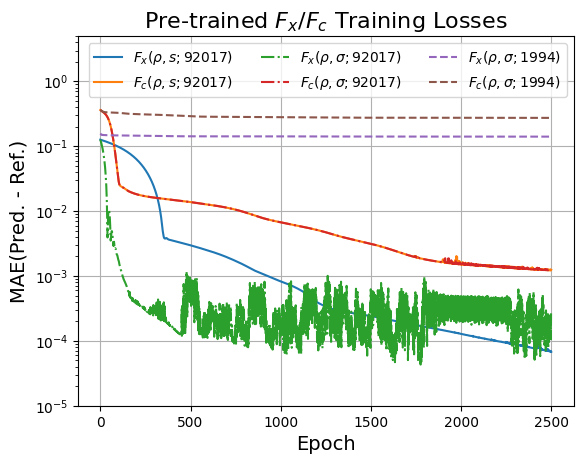

In [18]:
plt.plot(nlx, label='$F_x(\\rho,s;92017)$')
plt.plot(nlc, label='$F_c(\\rho,s;92017)$')
plt.plot(snlx, '-.', label='$F_x(\\rho,\\sigma;92017)$')
plt.plot(snlc, '-.', label='$F_c(\\rho,\\sigma;92017)$')
plt.plot(snlx2, '--', label='$F_x(\\rho,\\sigma;1994)$')
plt.plot(snlc2, '--', label='$F_c(\\rho,\\sigma;1994)$')
plt.yscale('log')
plt.xlabel('Epoch', fontsize=14)
plt.ylim(1e-5, 5e0)
plt.ylabel('MAE(Pred. - Ref.)', fontsize=14)
plt.title('Pre-trained $F_x$/$F_c$ Training Losses', fontsize=16)
plt.grid()
plt.legend(ncol=3)

In [19]:
siginputs.mean(axis=0), siginputs2.mean(axis=0)

(Array([  0.8072265 , 498.49542592], dtype=float64),
 Array([  0.82000703, 538.18504421], dtype=float64))

So the training selection evidently has a **huge** impact on the resulting network accuracy.

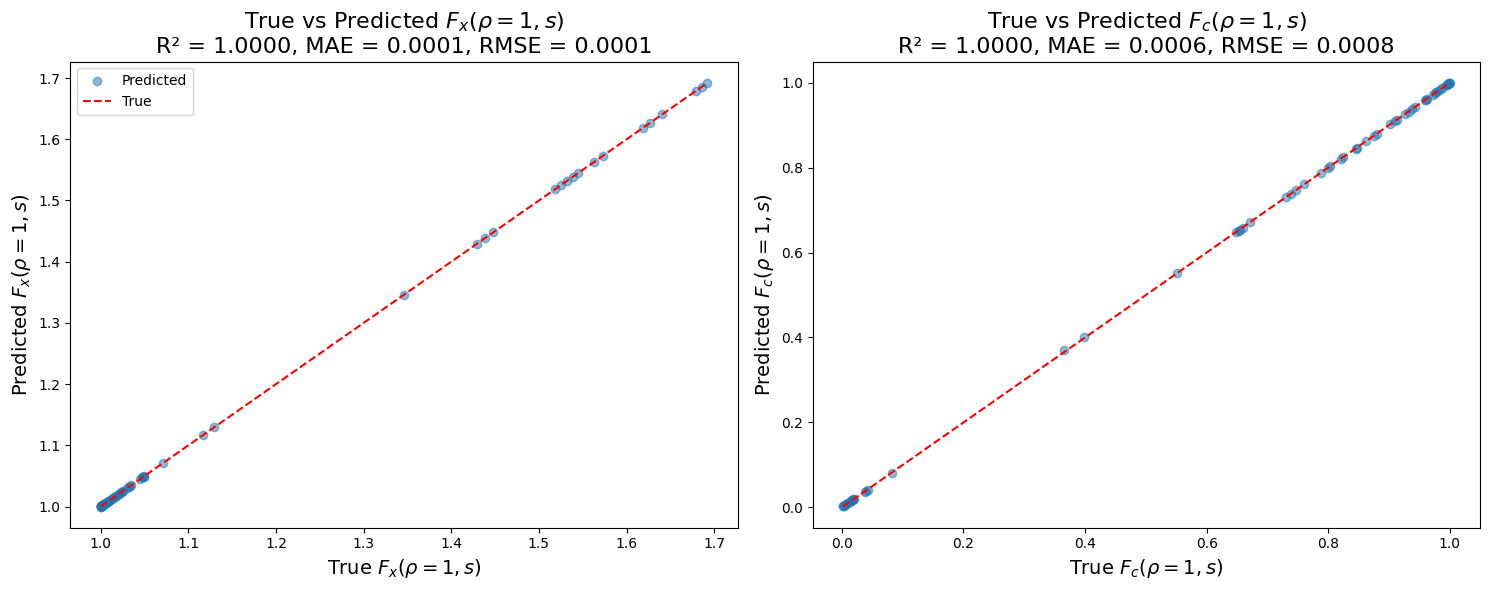

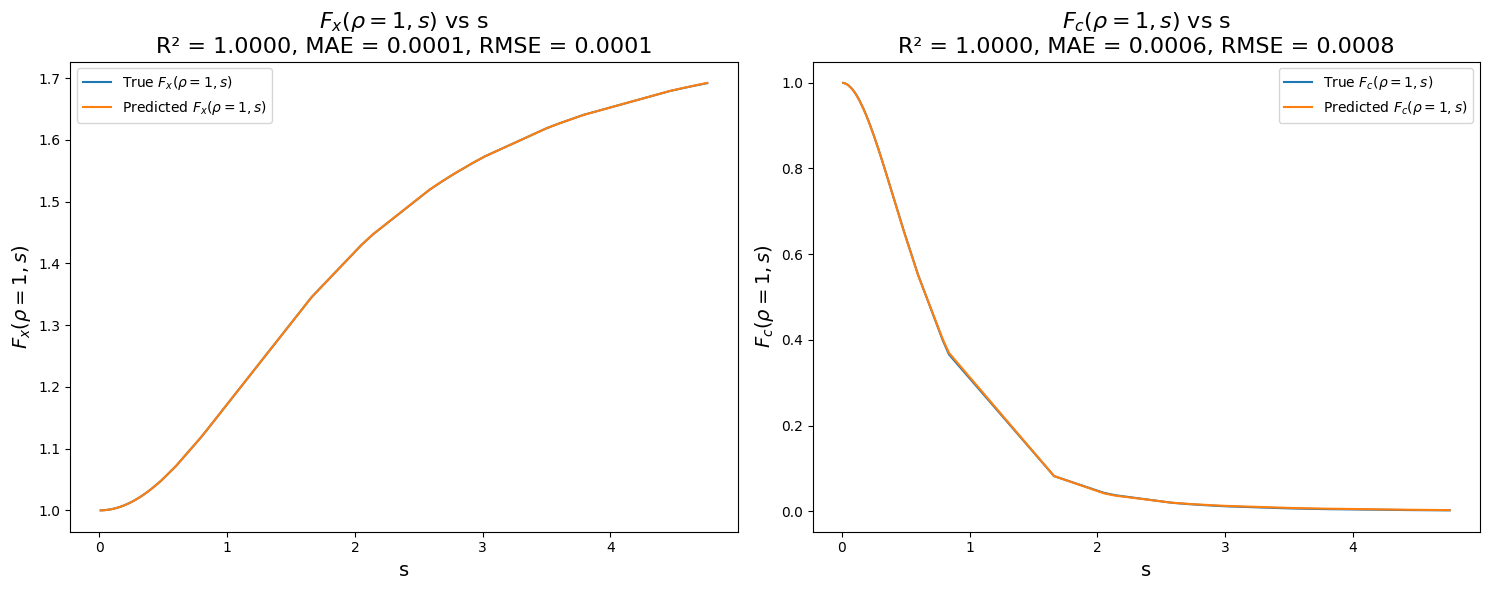

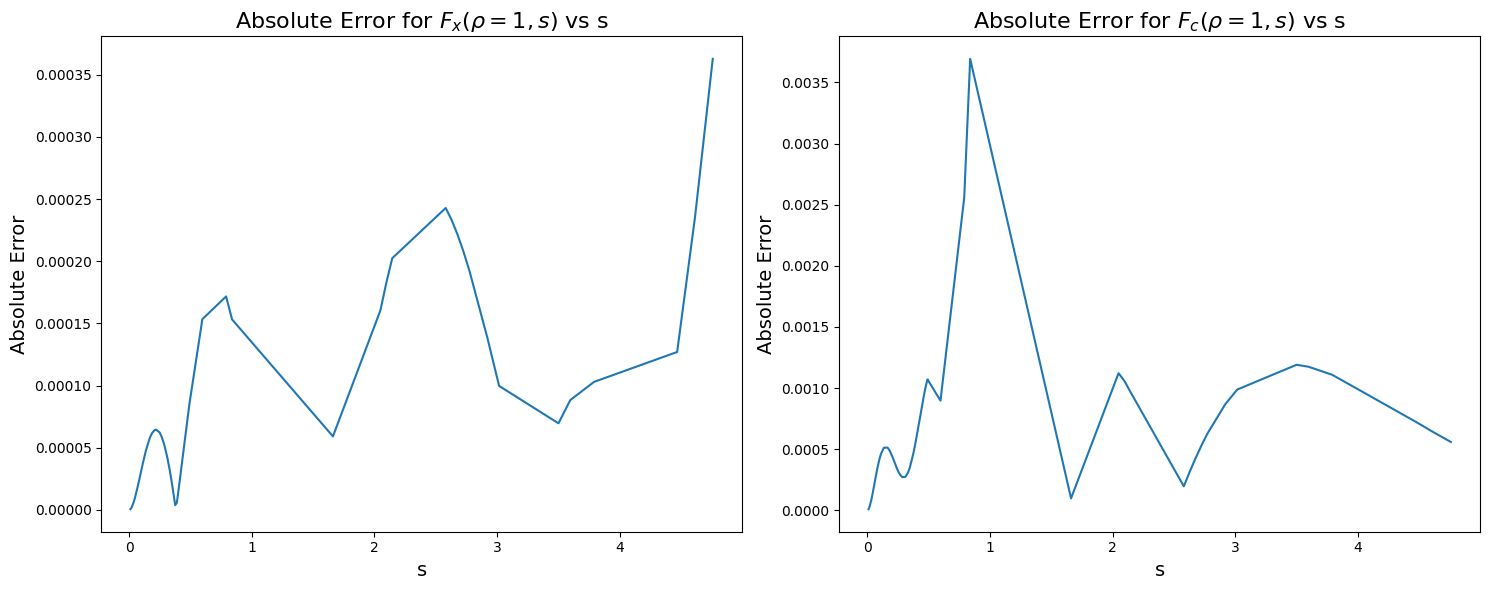

Fx Statistics:
R-squared: 1.000000
Mean Absolute Error: 0.000082
Root Mean Squared Error: 0.000111
Maximum Absolute Error: 0.000363

Fc Statistics:
R-squared: 0.999995
Mean Absolute Error: 0.000611
Root Mean Squared Error: 0.000834
Maximum Absolute Error: 0.003692


In [20]:
#for simplicity, we assume constant rho=1 for this test case and use the validation s; the 2d case will show the validation set using both
test_s = jnp.array(sorted(sv[val_inds]))
# test_rho = jnp.full_like(test_s, rv[val_inds].min())
test_rho = jnp.full_like(test_s, 1.0)
test_1d = jnp.stack([test_rho, test_s], axis=1)
# Calculate grad_rho for the test points
k_F_test = (3 * jnp.pi**2 * test_rho)**(1/3)
grad_rho_test = 2 * test_s * k_F_test * test_rho

# Calculate true PBE enhancement factors
true_fx_test = PBE_Fx(test_rho, grad_rho_test)
true_fc_test = PBE_Fc(test_rho, grad_rho_test)

pred_fx = jax.vmap(nmx)(test_1d)
pred_fc = jax.vmap(nmc)(test_1d)

# Calculate statistics
r2_fx, mae_fx, rmse_fx, max_error_fx = calculate_stats(true_fx_test, pred_fx)
r2_fc, mae_fc, rmse_fc, max_error_fc = calculate_stats(true_fc_test, pred_fc)
# 1. Correlation plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(true_fx_test, pred_fx, alpha=0.5, label='Predicted')
ax1.plot([true_fx_test.min(), true_fx_test.max()], [true_fx_test.min(), true_fx_test.max()], 'r--', label='True')
ax1.set_xlabel('True $F_x(\\rho=1, s)$', fontsize=14)
ax1.set_ylabel('Predicted $F_x(\\rho=1, s)$', fontsize=14)
ax1.set_title(f'True vs Predicted $F_x(\\rho=1, s)$\nR² = {r2_fx:.4f}, MAE = {mae_fx:.4f}, RMSE = {rmse_fx:.4f}', fontsize=16)
ax1.legend()

ax2.scatter(true_fc_test, pred_fc, alpha=0.5)
ax2.plot([true_fc_test.min(), true_fc_test.max()], [true_fc_test.min(), true_fc_test.max()], 'r--')
ax2.set_xlabel('True $F_c(\\rho=1, s)$', fontsize=14)
ax2.set_ylabel('Predicted $F_c(\\rho=1, s)$', fontsize=14)
ax2.set_title(f'True vs Predicted $F_c(\\rho=1, s)$\nR² = {r2_fc:.4f}, MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}', fontsize=16)

plt.tight_layout()
plt.show()

# 2. True PBE factors vs. s
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(test_s, true_fx_test, label='True $F_x(\\rho=1, s)$')
ax1.plot(test_s, pred_fx, label='Predicted $F_x(\\rho=1, s)$')
ax1.set_xlabel('s', fontsize=14)
ax1.set_ylabel('$F_x(\\rho=1, s)$', fontsize=14)
ax1.set_title(f'$F_x(\\rho=1, s)$ vs s\nR² = {r2_fx:.4f}, MAE = {mae_fx:.4f}, RMSE = {rmse_fx:.4f}', fontsize=16)
ax1.legend()

ax2.plot(test_s, true_fc_test, label='True $F_c(\\rho=1, s)$')
ax2.plot(test_s, pred_fc, label='Predicted $F_c(\\rho=1, s)$')
ax2.set_xlabel('s', fontsize=14)
ax2.set_ylabel('$F_c(\\rho=1, s)$', fontsize=14)
ax2.set_title(f'$F_c(\\rho=1, s)$ vs s\nR² = {r2_fc:.4f}, MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}', fontsize=16)
ax2.legend()

plt.tight_layout()
plt.show()

# 3. Error plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(test_s, np.abs(true_fx_test - pred_fx))
ax1.set_xlabel('s', fontsize=14)
ax1.set_ylabel('Absolute Error', fontsize=14)
ax1.set_title('Absolute Error for $F_x(\\rho=1, s)$ vs s', fontsize=16)

ax2.plot(test_s, np.abs(true_fc_test - pred_fc))
ax2.set_xlabel('s', fontsize=14)
ax2.set_ylabel('Absolute Error', fontsize=14)
ax2.set_title('Absolute Error for $F_c(\\rho=1, s)$ vs s', fontsize=16)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {r2_fx:.6f}")
print(f"Mean Absolute Error: {mae_fx:.6f}")
print(f"Root Mean Squared Error: {rmse_fx:.6f}")
print(f"Maximum Absolute Error: {max_error_fx:.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {r2_fc:.6f}")
print(f"Mean Absolute Error: {mae_fc:.6f}")
print(f"Root Mean Squared Error: {rmse_fc:.6f}")
print(f"Maximum Absolute Error: {max_error_fc:.6f}")

In [21]:
def plot_heatmap(true, pred, title, rho_values, s_values):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    im1 = ax1.imshow(true, aspect='auto', origin='lower', 
                     extent=[rho_values.min(), rho_values.max(), s_values.min(), s_values.max()], interpolation='none')
    ax1.set_title(f'True {title}')
    ax1.set_xlabel('s')
    ax1.set_ylabel('rho')
    # ax1.set_yscale('log')
    fig.colorbar(im1, ax=ax1)
    
    im2 = ax2.imshow(pred, aspect='auto', origin='lower', 
                     extent=[rho_values.min(), rho_values.max(), s_values.min(), s_values.max()])
    ax2.set_title(f'Predicted {title}')
    ax2.set_xlabel('s')
    ax2.set_ylabel('rho')
    # ax2.set_yscale('log')
    fig.colorbar(im2, ax=ax2)
    
    error = np.abs(true - pred)
    im3 = ax3.imshow(error, aspect='auto', origin='lower', 
                     extent=[rho_values.min(), rho_values.max(), s_values.min(), s_values.max()])
    ax3.set_title(f'Absolute Error for {title}')
    ax3.set_xlabel('s')
    ax3.set_ylabel('rho')
    # ax3.set_yscale('log')
    fig.colorbar(im3, ax=ax3)
    
    plt.tight_layout()
    plt.show()
    
def plot_contour(true, pred, title, rho_values, s_values, ylog=True, cmap='inferno', pred_vminmax = None, true_vminmax = None, levels=25, ncbarticks=5, coffset = 1e-4):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    if true_vminmax:
        print('Custom vmin/vmax set -- reading.')
        tvmin, tvmax = true_vminmax
    else:
        tvmin = round(true.min(), 1)
        tvmax = round(true.max(), 1)
    print('Contour: true values - vmin/vmax = {}/{}'.format(tvmin, tvmax))
    im1 = ax1.contourf(s_values, rho_values, true, cmap=cmap, vmin = tvmin-coffset, vmax = tvmax+coffset, levels=np.linspace(tvmin, tvmax, levels, endpoint=True))
    im1.set_clim(vmin=true.min(), vmax=true.max())
    ax1.set_title(f'True {title}', fontsize=16)
    ax1.set_xlabel('$s$', fontsize=14)
    ax1.set_ylabel('$\\rho$', fontsize=14)
    cbar1 = fig.colorbar(im1, ax=ax1, ticks=np.linspace(tvmin, tvmax, num=ncbarticks, endpoint=True))
    
    if pred_vminmax:
        print('Custom vmin/vmax set -- reading.')
        pvmin, pvmax = pred_vminmax
    else:
        pvmin = round(pred.min(), 1)
        pvmax = round(pred.max(), 1)
    print('Contour: pred values - vmin/vmax = {}/{}'.format(pvmin,  pvmax))
    im2 = ax2.contourf(s_values, rho_values, pred, cmap=cmap, vmin = pvmin-coffset, vmax = pvmax+coffset, levels=np.linspace(pvmin, pvmax, levels, endpoint=True))
    ax2.set_title(f'Predicted {title}', fontsize=16)
    ax2.set_xlabel('$s$', fontsize=14)
    ax2.set_ylabel('$\\rho$', fontsize=14)
    cbar2 = fig.colorbar(im2, ax=ax2, ticks=np.linspace(pvmin, pvmax, num=ncbarticks, endpoint=True))
    cbar2.ax.get_yaxis().set_ticks(np.linspace(tvmin, tvmax, num=ncbarticks, endpoint=True)) 
    
    error = np.abs(true - pred)
    print('Contour: error values - vmin/vmax = {}/{}'.format(error.min(), error.max()))
    im3 = ax3.contourf(s_values, rho_values, error, cmap=cmap, vmin = error.min(), vmax = error.max(), levels=np.linspace(error.min(), error.max(), levels, endpoint=True))
    ax3.set_title(f'Absolute Error for {title}', fontsize=16)
    ax3.set_xlabel('$s$', fontsize=14)
    ax3.set_ylabel('$\\rho$', fontsize=14)
    cbar3 = fig.colorbar(im3, ax=ax3, ticks=np.linspace(error.min(), error.max(), num=ncbarticks, endpoint=True))
    # im3.set_clim(vmin=error.min(), vmax=error.max())
    
    if ylog:
        ax1.set_yscale('log')
        ax2.set_yscale('log')
        ax3.set_yscale('log')

    plt.tight_layout()
    plt.show()


Fx Statistics:
R-squared: 1.000000
Mean Absolute Error: 0.000082
Root Mean Squared Error: 0.000111
Maximum Absolute Error: 0.000363

Fc Statistics:
R-squared: 0.999966
Mean Absolute Error: 0.001208
Root Mean Squared Error: 0.002306
Maximum Absolute Error: 0.020225
Custom vmin/vmax set -- reading.
Contour: true values - vmin/vmax = 1/1.7
Custom vmin/vmax set -- reading.
Contour: pred values - vmin/vmax = 1/1.7
Contour: error values - vmin/vmax = 5.265746287896889e-07/0.000362798404444975


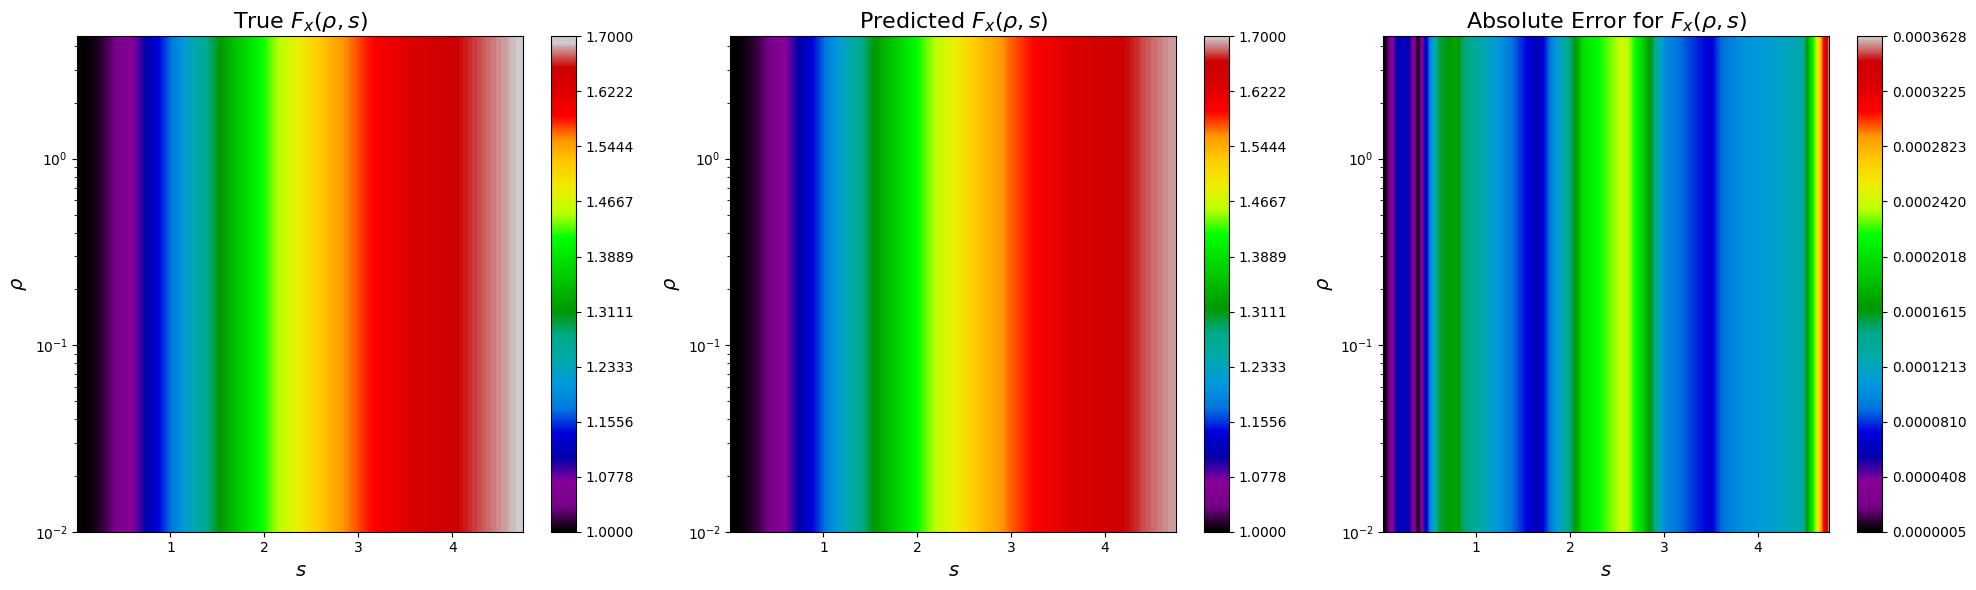

Custom vmin/vmax set -- reading.
Contour: true values - vmin/vmax = 0/1.0
Custom vmin/vmax set -- reading.
Contour: pred values - vmin/vmax = 0/1.0
Contour: error values - vmin/vmax = 1.728182819071833e-09/0.020224854988272867


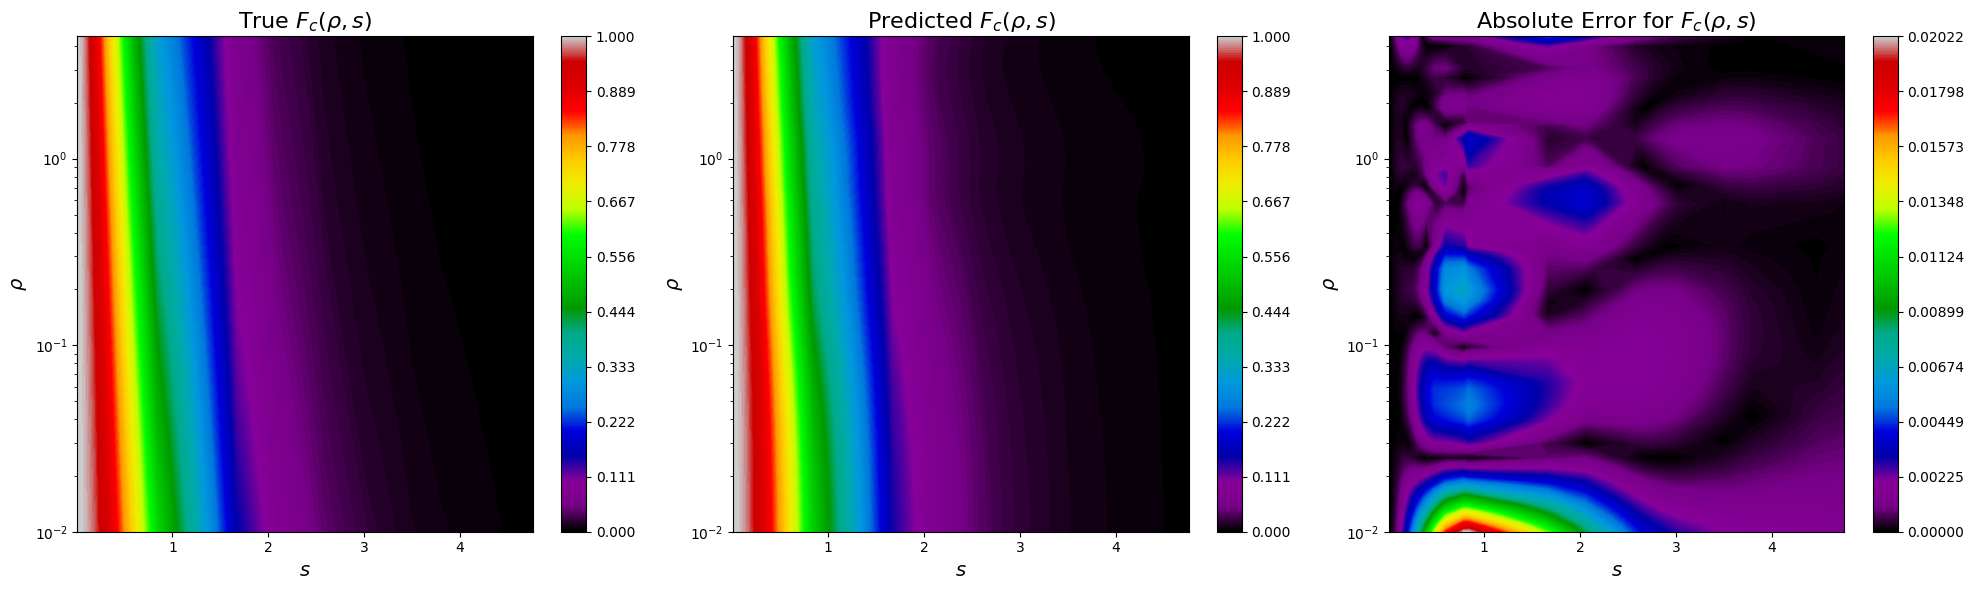

In [22]:
test_s = jnp.array(sorted(sv[val_inds]))
test_rho = jnp.array(sorted(rv[val_inds]))

NUM_S = len(test_s)
NUM_RHO = len(test_rho)

s_mesh, rho_mesh = jnp.meshgrid(test_s, test_rho)
k_F_test = (3 * jnp.pi**2 * rho_mesh)**(1/3)
grad_rho_test = 2 * s_mesh * k_F_test * rho_mesh
img_sinps = jnp.stack([rho_mesh.flatten(), s_mesh.flatten()], axis=1)

true_fx_test = PBE_Fx(rho_mesh.flatten(), grad_rho_test.flatten())
true_fc_test = PBE_Fc(rho_mesh.flatten(), grad_rho_test.flatten())

pred_fx = jax.vmap(nmx)(img_sinps)
pred_fc = jax.vmap(nmc)(img_sinps)

RSLEN = len(val_inds)

true_fx_test = true_fx_test.reshape(NUM_RHO, NUM_S)
true_fc_test = true_fc_test.reshape(NUM_RHO, NUM_S)
pred_fx = pred_fx.reshape(NUM_RHO, NUM_S)
pred_fc = pred_fc.reshape(NUM_RHO, NUM_S)

ir2_fx, imae_fx, irmse_fx, maxex = calculate_stats(true_fx_test, pred_fx)
ir2_fc, imae_fc, irmse_fc, maxec = calculate_stats(true_fc_test, pred_fc)
# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {ir2_fx:.6f}")
print(f"Mean Absolute Error: {imae_fx:.6f}")
print(f"Root Mean Squared Error: {irmse_fx:.6f}")
print(f"Maximum Absolute Error: {maxex:.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {ir2_fc:.6f}")
print(f"Mean Absolute Error: {imae_fc:.6f}")
print(f"Root Mean Squared Error: {irmse_fc:.6f}")
print(f"Maximum Absolute Error: {maxec:.6f}")
plot_contour(true_fx_test, pred_fx, '$F_x(\\rho, s)$', test_rho, test_s, cmap='nipy_spectral', pred_vminmax = (1, 1.7), true_vminmax = (1, 1.7), levels=500, ncbarticks = 10, coffset=0)
plot_contour(true_fc_test, pred_fc, '$F_c(\\rho, s)$', test_rho, test_s, cmap='nipy_spectral', pred_vminmax = (0, 1.0), true_vminmax = (0, 1.0), levels=500, ncbarticks = 10)


Fx Statistics:
R-squared: 0.999999
Mean Absolute Error: 0.000144
Root Mean Squared Error: 0.000280
Maximum Absolute Error: 0.000732

Fc Statistics:
R-squared: 0.999965
Mean Absolute Error: 0.001219
Root Mean Squared Error: 0.002344
Maximum Absolute Error: 0.020678
Custom vmin/vmax set -- reading.
Contour: true values - vmin/vmax = 1/1.7
Custom vmin/vmax set -- reading.
Contour: pred values - vmin/vmax = 1/1.7
Contour: error values - vmin/vmax = 1.6416778247929642e-07/0.0007315824472493571


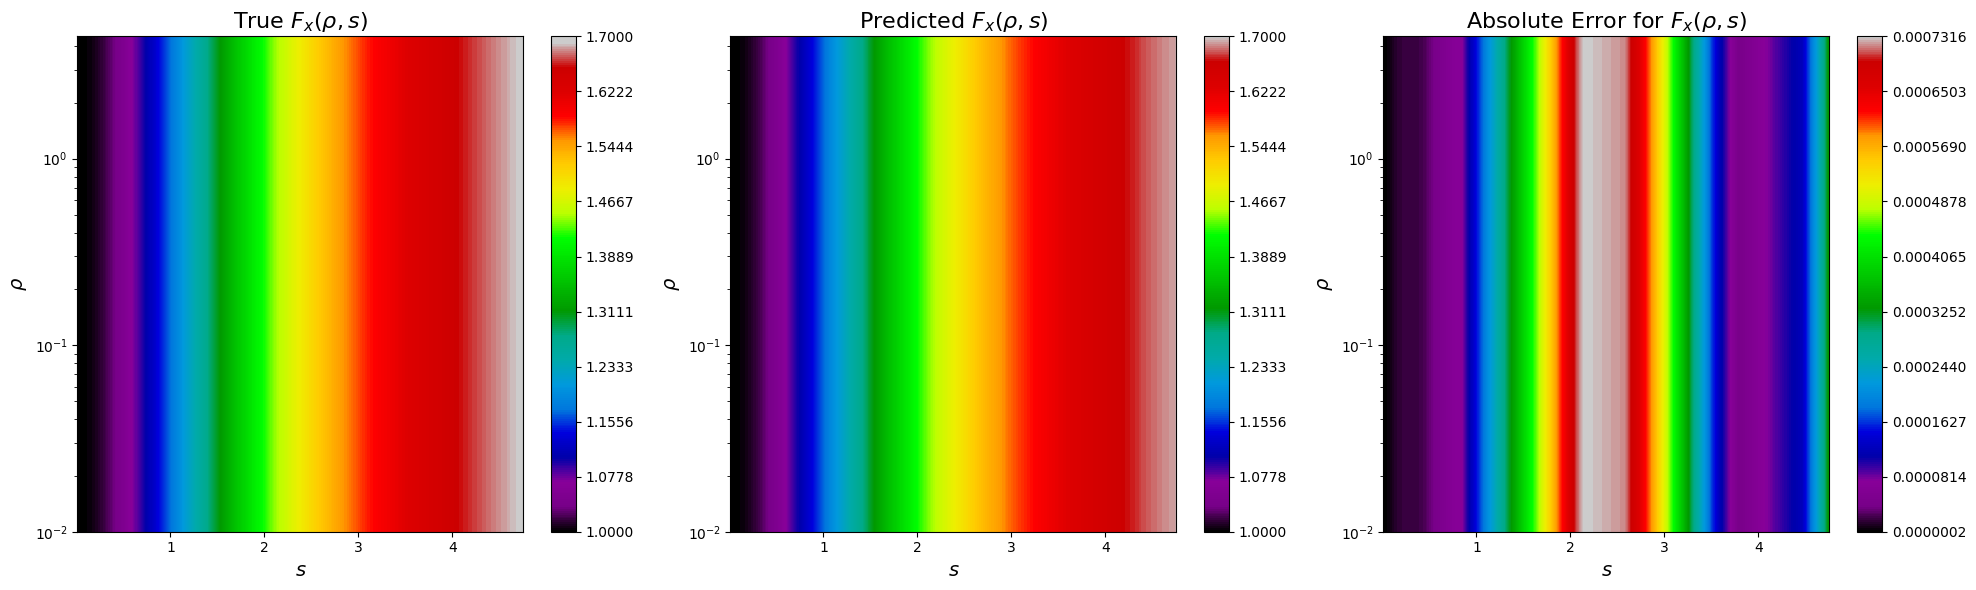

Custom vmin/vmax set -- reading.
Contour: true values - vmin/vmax = 0/1.0
Custom vmin/vmax set -- reading.
Contour: pred values - vmin/vmax = 0/1.0
Contour: error values - vmin/vmax = 1.774989477620892e-07/0.02067800111273821


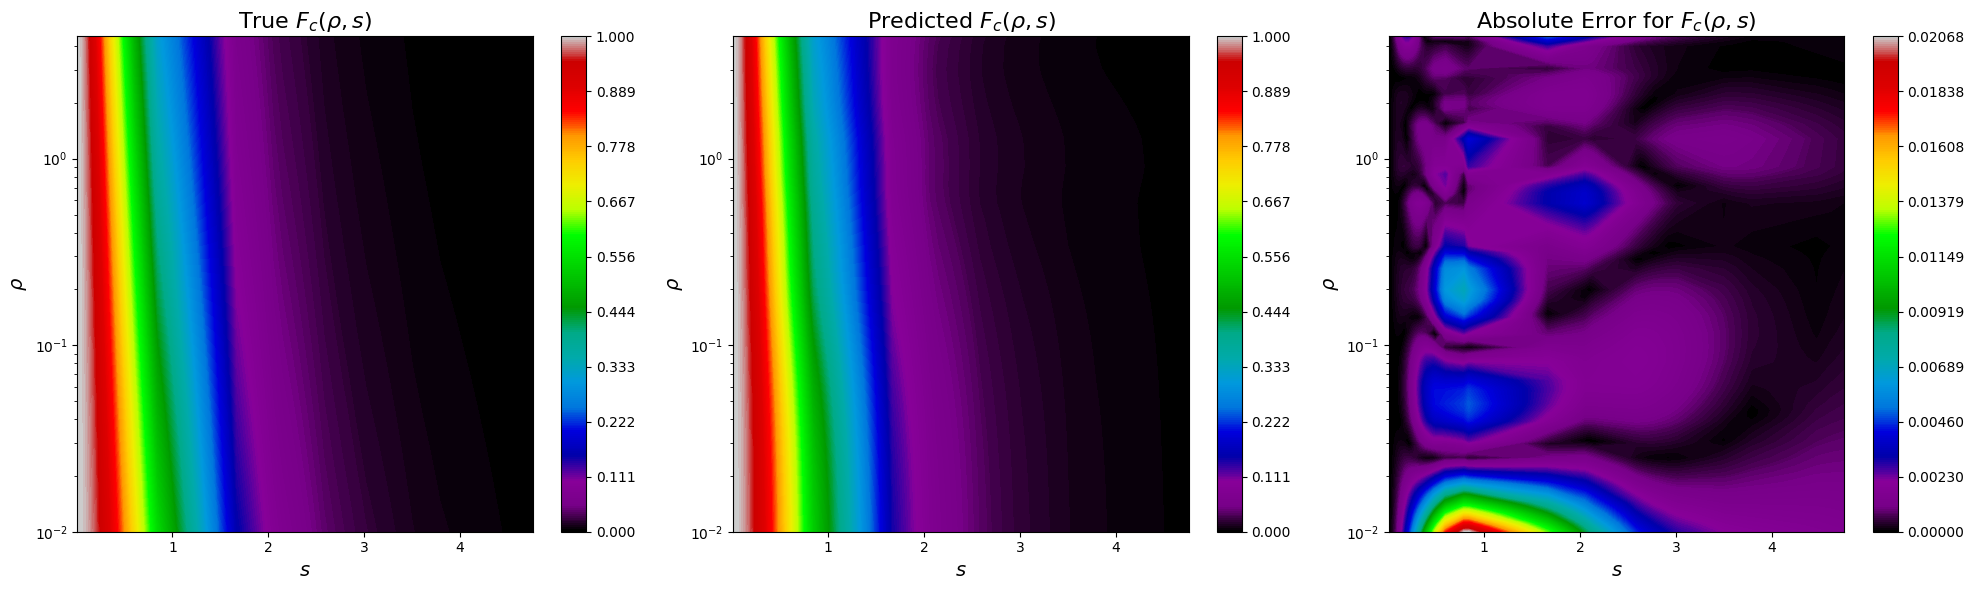

In [23]:
test_s = jnp.array(sorted(ssv[sval_inds]))
test_rho = jnp.array(sorted(srv[sval_inds]))

NUM_S = len(test_s)
NUM_RHO = len(test_rho)

s_mesh, rho_mesh = jnp.meshgrid(test_s, test_rho)
k_F_test = (3 * jnp.pi**2 * rho_mesh)**(1/3)
grad_rho_test = 2 * s_mesh * k_F_test * rho_mesh
img_sinps = jnp.stack([rho_mesh.flatten(), grad_rho_test.flatten()**2], axis=1)

true_fx_test = PBE_Fx(rho_mesh.flatten(), grad_rho_test.flatten())
true_fc_test = PBE_Fc(rho_mesh.flatten(), grad_rho_test.flatten())

pred_fx = jax.vmap(snmx)(img_sinps)
pred_fc = jax.vmap(snmc)(img_sinps)

RSLEN = len(val_inds)

true_fx_test = true_fx_test.reshape(NUM_RHO, NUM_S)
true_fc_test = true_fc_test.reshape(NUM_RHO, NUM_S)
pred_fx = pred_fx.reshape(NUM_RHO, NUM_S)
pred_fc = pred_fc.reshape(NUM_RHO, NUM_S)

ir2_fx, imae_fx, irmse_fx, maxex = calculate_stats(true_fx_test, pred_fx)
ir2_fc, imae_fc, irmse_fc, maxec = calculate_stats(true_fc_test, pred_fc)
# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {ir2_fx:.6f}")
print(f"Mean Absolute Error: {imae_fx:.6f}")
print(f"Root Mean Squared Error: {irmse_fx:.6f}")
print(f"Maximum Absolute Error: {maxex:.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {ir2_fc:.6f}")
print(f"Mean Absolute Error: {imae_fc:.6f}")
print(f"Root Mean Squared Error: {irmse_fc:.6f}")
print(f"Maximum Absolute Error: {maxec:.6f}")
plot_contour(true_fx_test, pred_fx, '$F_x(\\rho, s)$', test_rho, test_s, cmap='nipy_spectral', pred_vminmax = (1, 1.7), true_vminmax = (1, 1.7), levels=500, ncbarticks = 10, coffset=0)
plot_contour(true_fc_test, pred_fc, '$F_c(\\rho, s)$', test_rho, test_s, cmap='nipy_spectral', pred_vminmax = (0, 1.0), true_vminmax = (0, 1.0), levels=500, ncbarticks = 10)


To demonstrate the poor-performing networks.

Fx Statistics:
R-squared: -0.303968
Mean Absolute Error: 0.141200
Root Mean Squared Error: 0.256689
Maximum Absolute Error: 0.666660

Fc Statistics:
R-squared: -0.284798
Mean Absolute Error: 0.303213
Root Mean Squared Error: 0.424055
Maximum Absolute Error: 0.914967
Custom vmin/vmax set -- reading.
Contour: true values - vmin/vmax = 1/1.7
Custom vmin/vmax set -- reading.
Contour: pred values - vmin/vmax = 1/1.7
Contour: error values - vmin/vmax = 0.002023683638888274/0.666659730563109


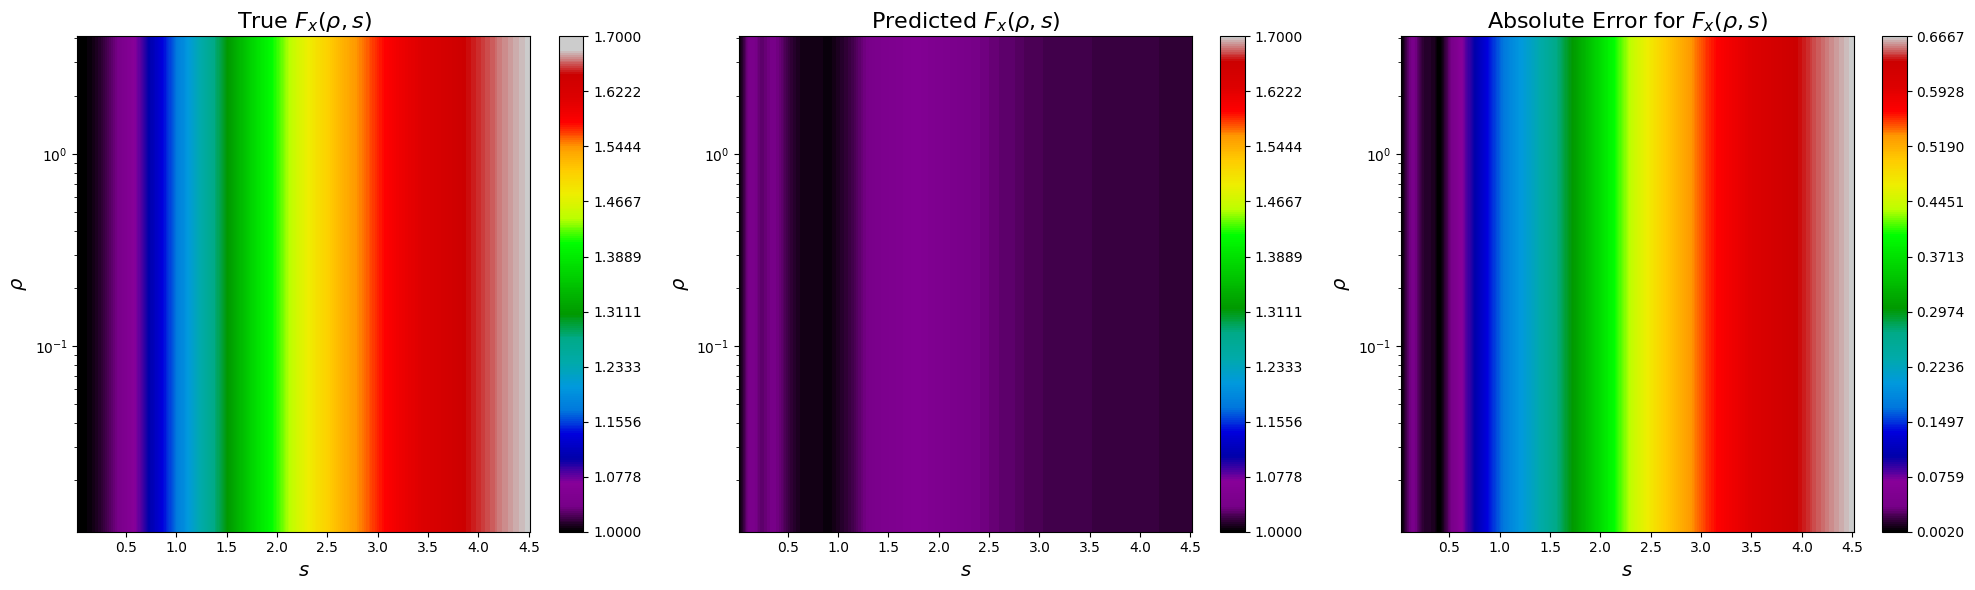

Custom vmin/vmax set -- reading.
Contour: true values - vmin/vmax = 0/1.0
Custom vmin/vmax set -- reading.
Contour: pred values - vmin/vmax = 0/1.0
Contour: error values - vmin/vmax = 5.281343844132369e-05/0.9149668394576016


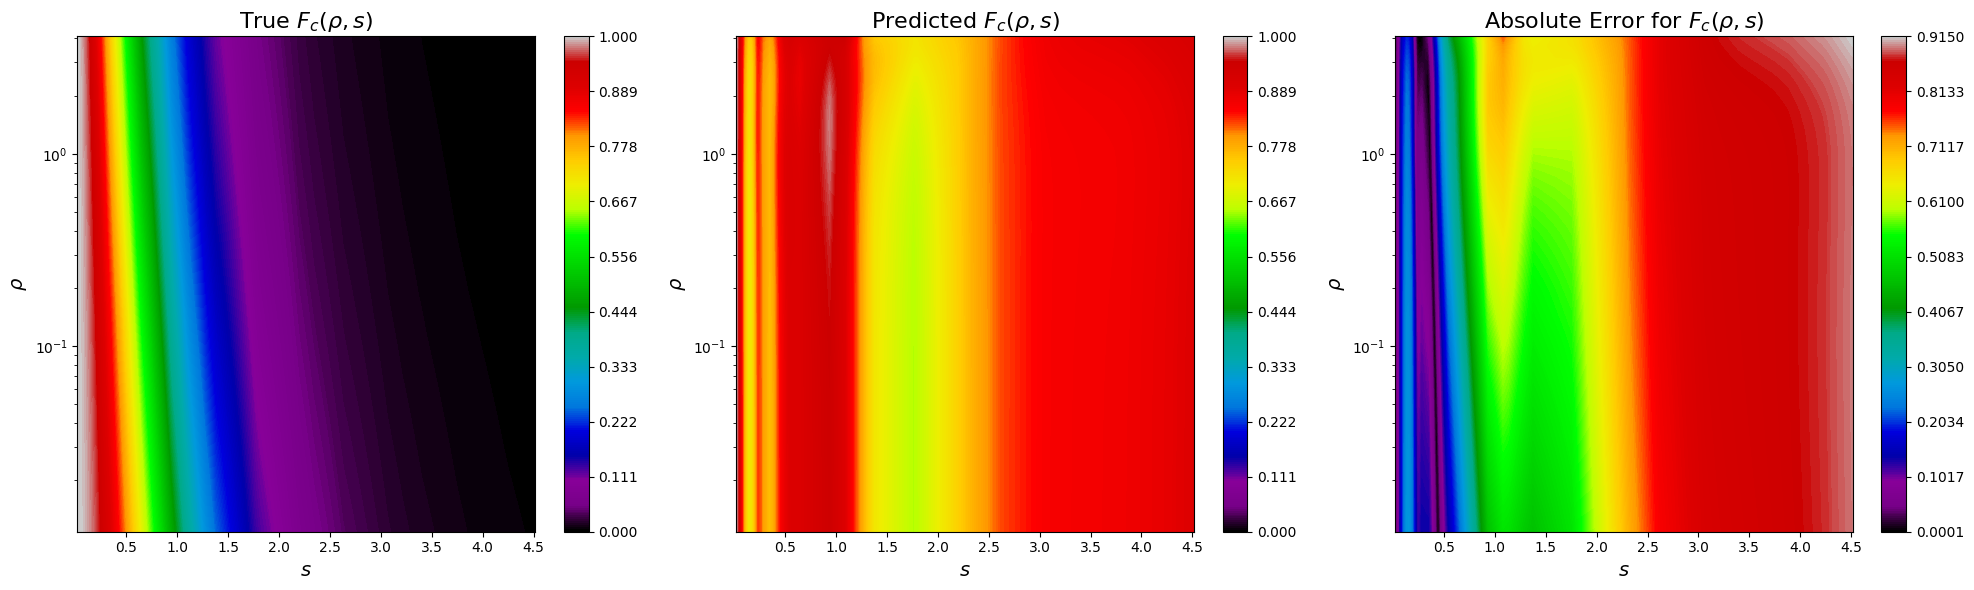

In [24]:
test_s = jnp.array(sorted(ssv2[sval_inds2]))
test_rho = jnp.array(sorted(srv2[sval_inds2]))

NUM_S = len(test_s)
NUM_RHO = len(test_rho)

s_mesh, rho_mesh = jnp.meshgrid(test_s, test_rho)
k_F_test = (3 * jnp.pi**2 * rho_mesh)**(1/3)
grad_rho_test = 2 * s_mesh * k_F_test * rho_mesh
img_sinps = jnp.stack([rho_mesh.flatten(), grad_rho_test.flatten()**2], axis=1)

true_fx_test = PBE_Fx(rho_mesh.flatten(), grad_rho_test.flatten())
true_fc_test = PBE_Fc(rho_mesh.flatten(), grad_rho_test.flatten())

pred_fx = jax.vmap(snmx2)(img_sinps)
pred_fc = jax.vmap(snmc2)(img_sinps)

RSLEN = len(val_inds)

true_fx_test = true_fx_test.reshape(NUM_RHO, NUM_S)
true_fc_test = true_fc_test.reshape(NUM_RHO, NUM_S)
pred_fx = pred_fx.reshape(NUM_RHO, NUM_S)
pred_fc = pred_fc.reshape(NUM_RHO, NUM_S)

ir2_fx, imae_fx, irmse_fx, maxex = calculate_stats(true_fx_test, pred_fx)
ir2_fc, imae_fc, irmse_fc, maxec = calculate_stats(true_fc_test, pred_fc)
# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {ir2_fx:.6f}")
print(f"Mean Absolute Error: {imae_fx:.6f}")
print(f"Root Mean Squared Error: {irmse_fx:.6f}")
print(f"Maximum Absolute Error: {maxex:.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {ir2_fc:.6f}")
print(f"Mean Absolute Error: {imae_fc:.6f}")
print(f"Root Mean Squared Error: {irmse_fc:.6f}")
print(f"Maximum Absolute Error: {maxec:.6f}")
plot_contour(true_fx_test, pred_fx, '$F_x(\\rho, s)$', test_rho, test_s, cmap='nipy_spectral', pred_vminmax = (1, 1.7), true_vminmax = (1, 1.7), levels=500, ncbarticks = 10, coffset=0)
plot_contour(true_fc_test, pred_fc, '$F_c(\\rho, s)$', test_rho, test_s, cmap='nipy_spectral', pred_vminmax = (0, 1.0), true_vminmax = (0, 1.0), levels=500, ncbarticks = 10)


# Optimizing PBE Networks

In [25]:
def custom_pbe_Fx(rho, sigma, XNET = None):
    #this will be a call to the Fx neural network we want
    # print('DEBUG custom_pbe_Fx, rho/sigma shapes: ', rho.shape, sigma.shape)
    # print('DEBUG custom_pbe_Fx: rho: ', rho)
    # print('DEBUG custom_pbe_Fx: sigma: ', sigma)

    Fx = XNET([rho, sigma])
    return Fx

def custom_pbe_Fc(rho, sigma, CNET = None): #Assumes zeta = 0
    #this will be a call to the Fc neural network we want
    Fc = CNET([rho, sigma])
    return Fc

def custom_pbe_e(rho, sigma, XNET = None, CNET = None):
    Fx = custom_pbe_Fx(rho, sigma, XNET = XNET)
    Fc = custom_pbe_Fc(rho, sigma, CNET = CNET)

    exc = lda_x(rho)*Fx + pw92c_unpolarized(rho)*Fc

    return exc

def custom_pbe_epsilon(rho, sigma, XNET = None, CNET = None):

    return rho*custom_pbe_e(rho, sigma, XNET = XNET, CNET = CNET)

def derivable_custom_pbe_e(rhosigma, XNET = None, CNET = None):
    rho, sigma = rhosigma
    # print('DEBUG derivable_custom_pbe_e: rhosigma len/shapes: ', len(rhosigma), rhosigma)
    # print('DEBUG derivable_custom_pbe_e: rho/sigma shapes: ', rho.shape, sigma.shape)
    # print('DEBUG derivable_custom_pbe_e: rho: ', rho)
    # print('DEBUG derivable_custom_pbe_e: sigma: ', sigma)
    return custom_pbe_e(rho, sigma, XNET = XNET, CNET = CNET)

def derivable_custom_pbe_epsilon(rhosigma, XNET = None, CNET = None):
    rho = rhosigma[0]
    sigma = rhosigma[1]
    result = custom_pbe_epsilon(rho, sigma, XNET = XNET, CNET = CNET)
    return result[0]
    
def eval_xc_gga_j(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None,
                 XNET = None, CNET = None):
    #we only expect there to be a rho0 array, but I unpack it as (rho, deriv) here to be in line with the
    #pyscf example -- the size of the 'rho' array depends on the xc type (LDA, GGA, etc.)
    #so since LDA calculation, check for size first.
    rho0, dx, dy, dz = rho[:4]
    rho0 = jnp.array(rho0)
    sigma = jnp.array(dx**2+dy**2+dz**2)
    # print('DEBUG eval_xc_gga_j: rho0/sigma shapes: ', rho0.shape, sigma.shape)
    rhosig = (rho0, sigma)
    #calculate the "custom" energy with rho -- THIS IS e
    #cast back to np.array since that's what pyscf works with
    #pass as tuple -- (rho, sigma)
    derivable_net_e = partial(derivable_custom_pbe_e, XNET = XNET, CNET = CNET)
    derivable_net_epsilon = partial(derivable_custom_pbe_epsilon, XNET = XNET, CNET = CNET)
    exc = np.array(jax.vmap(derivable_net_e)( rhosig ) )
    
    #first order derivatives w.r.t. rho and sigma
    vrho_f = eqx.filter_grad(derivable_net_epsilon)
    vrhosigma = np.array(jax.vmap(vrho_f)( rhosig ))
    # print('vrhosigma shape:', vrhosigma.shape)
    vxc = (vrhosigma[0], vrhosigma[1], None, None)

    # v2_f = eqx.filter_hessian(derivable_custom_pbe_epsilon)
    v2_f = jax.hessian(derivable_net_epsilon)
    # v2_f = jax.hessian(custom_pbe_epsilon, argnums=[0, 1])
    v2 = np.array(jax.vmap(v2_f)( rhosig ))
    # print('v2 shape', v2.shape)
    v2rho2 = v2[0][0]
    v2rhosigma = v2[0][1]
    v2sigma2 = v2[1][1]
    v2lapl2 = None
    vtau2 = None
    v2rholapl = None
    v2rhotau = None
    v2lapltau = None
    v2sigmalapl = None
    v2sigmatau = None
    # 2nd order functional derivative
    fxc = (v2rho2, v2rhosigma, v2sigma2, v2lapl2, vtau2, v2rholapl, v2rhotau, v2lapltau, v2sigmalapl, v2sigmatau)
    #3rd order
    kxc = None
    
    return exc, vxc, fxc, kxc

def eval_xc_gga_j2(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None,
                 xcmodel = None):
    #we only expect there to be a rho0 array, but I unpack it as (rho, deriv) here to be in line with the
    #pyscf example -- the size of the 'rho' array depends on the xc type (LDA, GGA, etc.)
    #so since LDA calculation, check for size first.
    try:
        rho0, dx, dy, dz = rho[:4]
        sigma = jnp.array(dx**2+dy**2+dz**2)
    except:
        rho0, drho = rho[:4]
        sigma = jnp.array(drho**2)
    rho0 = jnp.array(rho0)
    # sigma = jnp.array(dx**2+dy**2+dz**2)
    # print('DEBUG eval_xc_gga_j: rho0/sigma shapes: ', rho0.shape, sigma.shape)
    # rhosig = (rho0, sigma)
    rhosig = jnp.stack([rho0, sigma], axis=1)
    print(rhosig.shape)
    #calculate the "custom" energy with rho -- THIS IS e
    #cast back to np.array since that's what pyscf works with
    #pass as tuple -- (rho, sigma)
    exc = jax.vmap(xcmodel)(rhosig)
    exc = jnp.array(exc)/rho0
    # exc = jnp.array(jax.vmap(xcmodel)( rhosig ) )/rho0
    # print('exc shape = {}'.format(exc.shape))
    #first order derivatives w.r.t. rho and sigma
    vrho_f = eqx.filter_grad(xcmodel)
    vrhosigma = jnp.array(jax.vmap(vrho_f)( rhosig ))
    # print('vrhosigma shape:', vrhosigma.shape)
    vxc = (vrhosigma[:, 0], vrhosigma[:, 1], None, None)

    # v2_f = eqx.filter_hessian(derivable_custom_pbe_epsilon)
    v2_f = jax.hessian(xcmodel)
    # v2_f = jax.hessian(custom_pbe_epsilon, argnums=[0, 1])
    v2 = jnp.array(jax.vmap(v2_f)( rhosig ))
    print('v2 shape', v2.shape)
    v2rho2 = v2[:, 0, 0]
    v2rhosigma = v2[:, 0, 1]
    v2sigma2 = v2[:, 1, 1]
    v2lapl2 = None
    vtau2 = None
    v2rholapl = None
    v2rhotau = None
    v2lapltau = None
    v2sigmalapl = None
    v2sigmatau = None
    # 2nd order functional derivative
    fxc = (v2rho2, v2rhosigma, v2sigma2, v2lapl2, vtau2, v2rholapl, v2rhotau, v2lapltau, v2sigmalapl, v2sigmatau)
    #3rd order
    kxc = None
    
    return exc, vxc, fxc, kxc

In [26]:
mol = gto.M(
    atom = '''
    O  0.   0.       0.
    H  0.   -0.757   0.587
    H  0.   0.757    0.587 ''',
    basis = 'ccpvdz')
mol.verbose = 0
mol.max_memory = 32000
mf = dft.RKS(mol)
mf.grids.level = 1
mf.xc = 'pbe'
mf.kernel()
ao = dft.numint.eval_ao(mol, mf.grids.coords, deriv=1)
dm = mf.make_rdm1()
rho = dft.numint.eval_rho(mol, ao, dm, xctype='GGA')

In [27]:
mf.e_tot

-76.33342437818287

#### Do a CCSD(T) calculation to get a more accurate energy to target.

In [28]:
start_hf = scf.RHF(mol)
start_hf.kernel()
cc_h2o = cc.CCSD(start_hf)
cc_h2o.kernel()

(-0.21334324588829517,
 array([[ 6.32837811e-05,  9.32056211e-18, -3.47510396e-18,
         -4.60673625e-05,  7.40241332e-05, -1.61022272e-18,
          2.12688530e-17,  9.19758904e-05, -9.78673243e-19,
         -1.45047544e-19, -1.86187389e-04,  2.75746692e-17,
          2.09955407e-17,  8.62713654e-05, -1.38060468e-19,
          4.43377470e-20, -5.87393933e-06,  3.21678470e-05,
          1.21331040e-17],
        [-3.91228510e-03,  3.00402132e-16, -1.20374255e-15,
          3.57507648e-05, -4.24256897e-03,  1.73117560e-17,
          2.90082968e-16, -3.68473231e-04, -2.11640325e-19,
          7.09886345e-18, -1.47203123e-03,  4.06166028e-16,
          1.52780650e-16,  2.67542416e-03,  2.80389250e-18,
         -7.24076817e-18, -1.07208920e-04,  9.07975760e-04,
          4.12247811e-16],
        [-2.23868028e-15,  5.94474731e-03,  1.84260436e-03,
         -1.18049155e-16, -4.33238175e-16, -3.85679397e-17,
         -4.54656237e-03,  4.97432055e-16,  2.00316726e-18,
         -9.70993854e-1

In [29]:
cc_h2o.e_tot

-76.24010891900568

In [30]:
TARGET_ENERGY = cc_h2o.e_tot

In [31]:
@eqx.filter_value_and_grad
def opt_loss(model, mols, refs):
    total_loss = 0
    for idx, mol in enumerate(mols):
        mf = dft_ad.RKS(mol)
        custom_eval_xc = partial(eval_xc_gga_j2, xcmodel=model)
        mf.grids.level = 1
        mf.define_xc_(custom_eval_xc, 'GGA')
        mf.kernel()
        total_loss += abs(mf.e_tot - refs[idx])
    total_loss /= len(mols)
    return total_loss[..., jnp.newaxis][0]

In [32]:
class RXCModel(eqx.Module):
    xnet: eqx.Module
    cnet: eqx.Module

    def __init__(self, xnet, cnet):
        self.xnet = xnet
        self.cnet = cnet
        
    def __call__(self, inputs):
        #this generate epsilon, not exc -- divide end result by rho when needed
        rho = inputs[0]
        sigma = inputs[1]
        # print('RXCModel call - inputs {}'.format(inputs))
        return rho*(lda_x(rho)*jax.vmap(self.xnet)(inputs[..., jnp.newaxis]) + pw92c_unpolarized(rho)*jax.vmap(self.cnet)(inputs[..., jnp.newaxis])).flatten()[0]
        # return rho*(lda_x(rho)*self.xnet(inputs) + pw92c_unpolarized(rho)*self.cnet(inputs)).flatten()[0]

In [33]:
mol = gto.M(
    atom = '''
    O  0.   0.       0.
    H  0.   -0.757   0.587
    H  0.   0.757    0.587 ''',
    basis = 'ccpvdz')
mol.verbose = 0
mol.max_memory = 32000
molad = gto_ad.Mole(
    atom = '''
    O  0.   0.       0.
    H  0.   -0.757   0.587
    H  0.   0.757    0.587 ''',
    basis = 'ccpvdz')
molad.verbose = 0
molad.max_memory = 32000

test_model = RXCModel(xnet=snmx, cnet=snmc)
sigma_eval_xc = partial(eval_xc_gga_j2, xcmodel=test_model)
mf2 = dft_ad.RKS(molad)
mf2.grids.level = 1
mf2.define_xc_(sigma_eval_xc, 'GGA')
mf2.kernel()

Initialize <pyscfad.gto.mole.Mole object at 0x790aac276110> in RKS-KohnShamDFT object of <class 'pyscfad.dft.rks.RKS'>
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)


Array(-76.03221829, dtype=float64)

In [34]:
from typing import Callable

class Optimizer(eqx.Module):
    model: eqx.Module
    optim: optax.GradientTransformation
    steps: int
    print_every: int
    opt_state: tuple
    mols: list
    refs: jnp.array
    loss: Callable

    def __init__(self, model, optim, mols, refs, loss, steps=1000, print_every=100):
        '''
        The Pretrainer object aids in the initial pre-training of enhancement factor networks to have a more physical starting point for further network optimization. This class is meant to pre-train a randomly initialized network to fit the values of a specific XC functional's enhancement factor (either X or C, in principle it could also be a combined XC enhancement facator)

        :param model: The enhancement factor network to be pre-trained
        :type model: :xcquinox.net: class
        :param optim: The optimizer than will control the weight updates given a loss and gradient
        :type optim: optax.GradientTransformation
        :param inputs: The inputs the network itself is expecting in its forward pass function
        :type inputs: jnp.array
        :param ref: The reference values the network is expected to reproduce
        :type ref: jnp.array
        :param loss: A function from :xcquinox.loss: that is decorated with @eqx.filter_value_and_grad
        :type loss: Callable
        :param steps: Number of epochs to train over, defaults to 1000
        :type steps: int, optional
        :param print_every: How often to print loss statistic, defaults to 100
        :type print_every: int, optional
        '''
        super().__init__()
        self.model = model
        self.optim = optim
        self.mols = mols
        self.refs = refs
        self.steps = steps
        self.print_every = print_every
        self.opt_state = self.optim.init(eqx.filter(self.model, eqx.is_array))
        self.loss = loss

    def __call__(self):
        '''
        The training loop itself. Here, a loop over the specifed epochs takes place to train the network to fit reference values.

        :return: The trained model and an array of the losses during training.
        :rtype: (:xcquinox.net: class, array)
        '''
        losses = []
        for epoch in range(self.steps):
            if epoch == 0:
                this_model = self.model
                this_opt_state = self.opt_state
            loss, this_model, this_opt_state = self.make_step(this_model, self.mols, self.refs, this_opt_state)
            lossi = loss.item()
            losses.append(lossi)
            if epoch % self.print_every == 0:
                print(f'Epoch {epoch}: Loss = {lossi}')

        return this_model, losses

    # @eqx.filter_jit
    def make_step(self, model, inputs, ref, opt_state):
        '''
        The function that does each epoch's network update. It generates a loss and gradient using the specific :xcquinox.loss: function (that must be decorated with @eqx.filter_value_and_grad and only explicitly returns the loss value inside the function proper) given the specified inputs and reference values and initial optimization state.

        :param model: The enhancement factor network to be pre-trained
        :type model: :xcquinox.net: class
        :param inputs: The inputs the network itself is expecting in its forward pass function
        :type inputs: jnp.array
        :param ref: The reference values the network is expected to reproduce
        :type ref: jnp.array
        :param opt_state: The INITIAL optimization state to work against, typically generated via :self.optim.init(eqx.filter(self.model, eqx.is_array)):
        :type opt_state: The type of the above
        :return: The loss value for this step, the updated model after that loss is calculated, and the new optimization state for this step to use next time
        :rtype: tuple
        '''
        loss, grad = self.loss(model, self.mols, self.refs)
        updates, opt_state = self.optim.update(grad, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state


In [ ]:
mol_ad = gto_ad.Mole(
    atom = '''
    O  0.   0.       0.
    H  0.   -0.757   0.587
    H  0.   0.757    0.587 ''',
    basis = 'ccpvdz')
mol_ad.max_memory = 32000
mol_ad.build()
mol_ad.verbose = 0
OPT_INIT_LR = 1e-2
OPT_END_LR = 1e-5
OPTSTEPS = 100
OPTDECAYBEGIN = 30
# OPTDECAYRATE = 0.95
scheduler = optax.linear_schedule(
    init_value = OPT_INIT_LR,
    transition_steps = OPTSTEPS-OPTDECAYBEGIN,
    transition_begin = OPTDECAYBEGIN,
    end_value = OPT_END_LR,
)
opt_opt = optax.adam(learning_rate=scheduler)
opt_snmxc = Optimizer(model=test_model, optim=opt_opt, mols = [mol_ad], refs = [TARGET_ENERGY], loss=opt_loss, print_every=1, steps=OPTSTEPS)

In [36]:
osnmxc, osnmxcl = opt_snmxc()

/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(9082, 2)
v2 shape (9082, 2, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
Epoch 0: Loss = 0.20789062848410822


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
Epoch 1: Loss = 0.08873609315088515
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
Epoch 2: Loss = 0.044355820204131646
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)
(9082, 2)
v2 shape (9082, 2, 2)

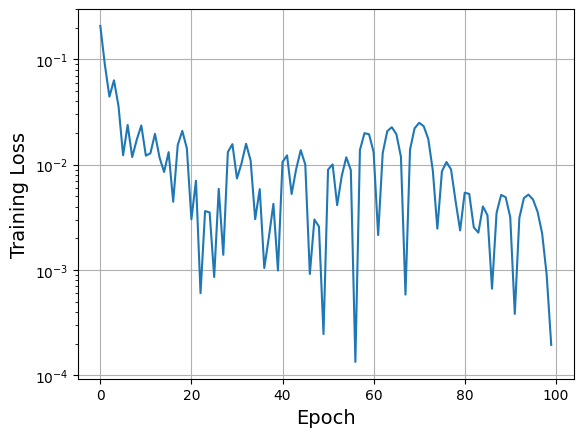

In [37]:
plt.plot(osnmxcl)
plt.yscale('log')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Training Loss', fontsize=14)
plt.grid()

In [38]:
sigma_eval_xc_opt = partial(eval_xc_gga_j2, xcmodel=osnmxc)
mf3 = dft.RKS(mol)
mf3.grids.level = 1
mf3.define_xc_(sigma_eval_xc_opt, 'GGA')
mf3.kernel()

(9088, 2)
v2 shape (9088, 2, 2)
(9088, 2)
v2 shape (9088, 2, 2)
(9088, 2)
v2 shape (9088, 2, 2)
(9088, 2)
v2 shape (9088, 2, 2)
(9088, 2)
v2 shape (9088, 2, 2)
(9088, 2)
v2 shape (9088, 2, 2)
(9088, 2)
v2 shape (9088, 2, 2)
(9088, 2)
v2 shape (9088, 2, 2)
(9088, 2)
v2 shape (9088, 2, 2)
(9088, 2)
v2 shape (9088, 2, 2)
(9088, 2)
v2 shape (9088, 2, 2)
(9088, 2)
v2 shape (9088, 2, 2)


-76.24066563993489

In [39]:
# Define the neural network module for Fx
class GGA_FxNet_sigma_UNC(eqx.Module):
    depth: int
    nodes: int
    seed: int
    lob_lim: float
    lower_rho_cutoff: float
    net: eqx.nn.MLP

    def __init__(self, depth: int, nodes: int, seed: int, lob_lim=1.804, lower_rho_cutoff = 1e-12):
        '''
        Constructor for the exchange enhancement factor object, for the GGA case.

        In a GGA XC functional, the relevant quantities are (rho, grad_rho). Here, the network's input size is hard-coded to 1 -- just the gradient information is passed to the network, to guarantee that the energy yielded from this multiplicative factor behaves correctly under uniform scaling of the electron density and obeys the spin-scaling relation.

        :param depth: Depth of the neural network
        :type depth: int
        :param nodes: Number of nodes in each layer
        :type nodes: int
        :param seed: The random seed to initiate baseline weight values for the network
        :type seed: int
        :param lob_lim: The Lieb-Oxford bound to respect, defaults to 1.804
        :type lob_lim: float, optional
        :param lower_rho_cutoff: a cut-off to bypass potential division by zero in the division by rho, defaults to 1e-12
        :type lower_rho_cutoff: float, optional
        '''
        self.depth = depth
        self.nodes = nodes
        self.seed = seed
        self.lob_lim = lob_lim
        self.lower_rho_cutoff = lower_rho_cutoff
        self.net = eqx.nn.MLP(in_size = 2, # Input is rho, gradient_descriptor
                              out_size = 1, # Output is Fx
                              depth = self.depth,
                              width_size = self.nodes,
                              activation = jax.nn.gelu,
                              key = jax.random.PRNGKey(self.seed))

    def __call__(self, inputs):
        '''
        The network's forward pass, resulting in the enhancement factor associated to the input gradient descriptor.

        *NOTE*: This forward pass is explicitly NOT vectorized -- it expects one grid point worth of data, the (rho, gradient_descriptor) values at that point. This structure expects the :jax.vmap: call to be coded OUTSIDE of the network class.

        *NOTE*: Here, the gradient_descriptor is assumed to be Libxc's/PySCF's internal variable for the density gradient -- sigma (gradient squared in non-spin-polarized, gradient contracted with itself in spin-polarized). This is so that we have easy access to automatic derivatives with respect to sigma, thus can generate v_sigma and use in convergence testing. However, within the call sigma is translated to the reduced density gradient, :s:, which the network is still assumed to be parameterized by, and the call is structured in such a way to respect the UEG limits for when gradients vanish. Namely, when s = 0, Fx = 1, so the resulting e = Fx*e_heg = e_heg.

        :param inputs: _description_
        :type inputs: tuple, list, array of size 2 in order (rho, gradient_descriptor)
        :return: The enhancement factor value
        :rtype: float
        '''
        #here, assume the inputs is [rho, sigma] and select the appropriate input
        #takes forever if inputs[1] tanh input has extended shape , i.e. (1,1) as opposed to scalar shape (1,)
        rho = jnp.maximum(self.lower_rho_cutoff, inputs[0]) #Prevents division by 0
        rho = rho.flatten()
        sigma = jnp.maximum(self.lower_rho_cutoff, inputs[1]) #Prevents division by 0
        sigma = sigma.flatten()
        k_F = (3 * jnp.pi**2 * rho)**(1/3)
        s = jnp.sqrt(sigma) / (2 * k_F * rho)
        s = s.flatten()
        netinp = jnp.stack([rho, s], axis=0).flatten()
        netterm = self.net(netinp)
        return netterm.squeeze()

# Define the neural network module for Fc
class GGA_FcNet_sigma_UNC(eqx.Module):
    depth: int
    nodes: int
    seed: int
    lob_lim: float
    lower_rho_cutoff: float
    net: eqx.nn.MLP


    def __init__(self, depth: int, nodes: int, seed: int, lob_lim=2.0, lower_rho_cutoff = 1e-12):
        '''
        Constructor for the correlation enhancement factor object, for the GGA case.

        In a GGA XC functional, the relevant quantities are (rho, grad_rho). Here, the network's input size is hard-coded to 2 -- both the density and gradient information is passed to the network.

        The default Lieb-Oxford bound the outputs are wrapped here is set to 2.0, to enforce the non-negativity of the correlation energy.

        :param depth: Depth of the neural network
        :type depth: int
        :param nodes: Number of nodes in each layer
        :type nodes: int
        :param seed: The random seed to initiate baseline weight values for the network
        :type seed: int
        :param lob_lim: The Lieb-Oxford bound to respect, defaults to 2
        :type lob_lim: float, optional
        :param lower_rho_cutoff: a cut-off to bypass potential division by zero in the division by rho, defaults to 1e-12
        :type lower_rho_cutoff: float, optional
        '''
        self.depth = depth
        self.nodes = nodes
        self.seed = seed
        self.lob_lim = lob_lim
        self.lower_rho_cutoff = lower_rho_cutoff
        self.net = eqx.nn.MLP(in_size = 2, # Input is rho, gradient_descriptor
                              out_size = 1, # Output is Fc
                              depth = self.depth,
                              width_size = self.nodes,
                              activation = jax.nn.gelu,
                              key = jax.random.PRNGKey(self.seed))

    def __call__(self, inputs):
        '''
        The network's forward pass, resulting in the enhancement factor associated to the input gradient descriptor.

        *NOTE*: This forward pass is explicitly NOT vectorized -- it expects one grid point worth of data, the (rho, gradient_descriptor) values at that point. This structure expects the :jax.vmap: call to be coded OUTSIDE of the network class.

        *NOTE*: Here, the gradient_descriptor is assumed to be Libxc's/PySCF's internal variable for the density gradient -- sigma (gradient squared in non-spin-polarized, gradient contracted with itself in spin-polarized). This is so that we have easy access to automatic derivatives with respect to sigma, thus can generate v_sigma and use in convergence testing. However, within the call sigma is translated to the reduced density gradient, :s:, which the network is still assumed to be parameterized by, and the call is structured in such a way to respect the UEG limits for when gradients vanish. Namely, when s = 0, Fx = 1, so the resulting e = Fx*e_heg = e_heg.

        :param inputs: _description_
        :type inputs: tuple, list, array of size 2 in order (rho, gradient_descriptor)
        :return: The enhancement factor value
        :rtype: float
        '''
        #here, assume the inputs is [rho, sigma] and select the appropriate input
        #takes forever if inputs[1] tanh input has extended shape , i.e. (1,1) as opposed to scalar shape (1,)
        rho = jnp.maximum(self.lower_rho_cutoff, inputs[0]) #Prevents division by 0
        rho = rho.flatten()
        sigma = jnp.maximum(self.lower_rho_cutoff, inputs[1]) #Prevents division by 0
        sigma = sigma.flatten()
        k_F = (3 * jnp.pi**2 * rho)**(1/3)
        s = jnp.sqrt(sigma) / (2 * k_F * rho)
        s = s.flatten()
        netinp = jnp.stack([rho, s], axis=0).flatten()
        netterm = self.net(netinp)
        return netterm.squeeze()

In [40]:
ran_unc = RXCModel(xnet = GGA_FxNet_sigma_UNC(depth=3, nodes=16, seed=92017), cnet = GGA_FcNet_sigma_UNC(depth=3, nodes=16, seed=92017))
#random network, un pre-trained
ran_model = RXCModel(xnet = spbe_fx, cnet = spbe_fc)
#pre-trained network
pt_model = RXCModel(xnet = snmx, cnet = snmc)
#optimized network
opt_model = osnmxc

# Testing - WATER27 Dataset

In [41]:
w27systems = {
    'OHmH2O4c4' : { 'atoms' : ['H', 'H', 'H', 'H', 'O', 'H', 'O', 'O', 'O', 'O', 'H', 'H', 'H', 'H'], 'coords' : [[-0.0267918, 1.5818251, 0.2834249], [1.5818251, 0.0267918, 0.2834249], [0.0267918, -1.5818251, 0.2834249], [-1.5818251, -0.0267918, 0.2834249], [0.0, 0.0, 0.9578999], [0.0, 0.0, 1.9177035], [0.0314199, 2.4185664, -0.2529905], [2.4185664, -0.0314199, -0.2529905], [-0.0314199, -2.4185664, -0.2529905], [-2.4185664, 0.0314199, -0.2529905], [0.843048, 2.2785225, -0.7493353], [2.2785225, -0.843048, -0.7493353], [-0.843048, -2.2785225, -0.7493353], [-2.2785225, 0.843048, -0.7493353]], 'charge' : -1, 'spin' : 0 },
    'H2O8d2d' : { 'atoms' : ['O', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'O', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'], 'coords' : [[-1.4645552, -1.4645552, 1.3497067], [-1.4645552, 1.4645552, -1.3497067], [1.4645552, -1.4645552, -1.3497067], [1.4645552, 1.4645552, 1.3497067], [-1.5346654, -1.5346654, 0.3622554], [-1.5346654, 1.5346654, -0.3622554], [1.5346654, -1.5346654, -0.3622554], [1.5346654, 1.5346654, 0.3622554], [-2.0896636, -2.0896636, 1.7251112], [-2.0896636, 2.0896636, -1.7251112], [2.0896636, -2.0896636, -1.7251112], [2.0896636, 2.0896636, 1.7251112], [-1.4052886, -1.4052886, -1.3390082], [-1.4052886, 1.4052886, 1.3390082], [1.4052886, -1.4052886, 1.3390082], [1.4052886, 1.4052886, -1.3390082], [-1.5526158, -0.4620645, -1.5268989], [-1.5526158, 0.4620645, 1.5268989], [1.5526158, -0.4620645, 1.5268989], [-0.4620645, -1.5526158, -1.5268989], [0.4620645, 1.5526158, -1.5268989], [0.4620645, -1.5526158, 1.5268989], [-0.4620645, 1.5526158, 1.5268989], [1.5526158, 0.4620645, -1.5268989]], 'charge' : 0, 'spin' : 0 },
    'H2O20es' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[1.4449507, -2.3192362, 1.3852172], [0.9523409, -1.4842602, 1.5288696], [2.3694569, -2.1139495, 1.6116655], [1.4198689, -2.4626094, -1.4007113], [1.4412349, -2.4945724, -0.4194091], [0.7771617, -3.1468464, -1.6575718], [0.0068371, 0.0172196, 1.4027157], [0.3893324, 0.9065634, 1.5625403], [-0.9609503, 0.0503272, 1.5609821], [-2.7367283, -0.0717073, 1.3588421], [-2.7881947, -0.0946107, 0.3779034], [-2.9785985, -0.9717563, 1.6413949], [4.0454641, 1.4627919, -1.4612681], [4.7881071, 1.7639854, -1.9912934], [4.0333238, 0.4731882, -1.5313495], [-1.0008037, 4.2249605, 1.4982864], [-1.152189, 5.0082615, 2.0335617], [-1.8328395, 3.6856129, 1.5416327], [-3.2272404, 2.7492225, -1.5453255], [-3.8412573, 3.2117349, -2.121788], [-2.3703373, 3.2485931, -1.5888707], [0.061546, -0.0608668, -1.3504788], [0.5404095, -0.8892136, -1.5688996], [0.0525024, -0.0517312, -0.3661063], [1.3505765, 2.3624375, -1.4255501], [2.2943427, 2.2180386, -1.6165285], [0.9255618, 1.4877943, -1.5595341], [4.0797114, -1.2705898, 1.5101742], [4.8184302, -1.5307198, 2.0667554], [4.0088205, -0.2833084, 1.5792807], [-0.9118416, 4.114684, -1.3968277], [-0.8699572, 4.3289684, -0.4493559], [-0.0897473, 3.6305502, -1.5859742], [-2.6850195, -0.0424816, -1.4274401], [-2.9831436, 0.8560006, -1.6562177], [-1.7132338, -0.0438086, -1.5635337], [-3.1295491, -2.8665515, -1.3299376], [-3.1140901, -1.9191429, -1.5480976], [-3.3032413, -2.9025862, -0.3736924], [1.224434, 2.4780105, 1.3595377], [0.5812433, 3.1657978, 1.6076146], [1.272843, 2.5161003, 0.3793006], [-0.812813, -4.2331318, -1.5239325], [-0.9466607, -5.0213678, -2.0566534], [-1.663369, -3.7232425, -1.5543692], [-3.2498861, 2.7544587, 1.3479831], [-3.1924627, 1.8120206, 1.5790401], [-3.4347595, 2.7666931, 0.3928574], [4.0373837, -1.2313563, -1.3812425], [3.2335259, -1.7195098, -1.6240819], [4.1604036, -1.4012254, -0.4312943], [-3.094015, -2.885118, 1.5661544], [-2.2180185, -3.3510614, 1.5943976], [-3.6898242, -3.3867826, 2.1285951], [-0.7332536, -4.1659349, 1.3697764], [0.0709231, -3.6538397, 1.5619151], [-0.6879895, -4.3597798, 0.4176959], [3.9098072, 1.4164687, 1.4257218], [3.0660482, 1.8495739, 1.636771], [4.0554225, 1.5928403, 0.4801529]], 'charge' : 0, 'spin' : 0 },
    'H2O20fs' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[-0.4674337, -1.4156432, 2.3424832], [-0.5103881, -0.5327785, 2.7383509], [-1.154371, -1.4135419, 1.6390602], [-1.1804953, -4.411489, -2.0217879], [-1.6005951, -5.0804995, -2.5684061], [-1.6296589, -4.4443491, -1.1306922], [-0.3890822, -4.3416186, 2.3649217], [-0.4122318, -3.4254374, 2.6780297], [0.495447, -4.4516812, 1.9766411], [-2.370827, -1.4010748, 0.3317388], [-2.7687053, -0.5190604, 0.3764393], [-1.9008133, -1.4312776, -0.5314561], [-1.0412215, -1.5773429, -2.0898648], [-0.0740952, -1.5478577, -1.9182976], [-1.2210828, -2.5028893, -2.3334269], [1.6403031, -4.3519848, -1.6030968], [0.6907637, -4.4791178, -1.78646], [1.8234428, -3.4332488, -1.8548591], [-2.332464, -4.3191108, 0.3710663], [-1.6749165, -4.4161499, 1.0945673], [-2.663344, -3.4130595, 0.4587135], [1.6787401, -1.4676579, -1.5895498], [1.8042491, -1.4683808, -0.6135222], [1.9691284, -0.5921861, -1.8871045], [2.0177788, -1.5700244, 1.1457336], [1.1343262, -1.5367783, 1.5764315], [2.3187166, -2.4899023, 1.2541941], [2.1824622, -4.3930741, 1.0311736], [2.8554348, -5.0463468, 1.2384494], [2.0031126, -4.4627308, 0.0573709], [-0.4152401, 4.3842505, 2.2876138], [-0.5679834, 5.06537, 2.9479304], [-1.1127701, 4.487654, 1.6038264], [-1.1046614, 1.2760042, -2.0786808], [-1.2737935, 0.3860585, -2.4278927], [-1.5421398, 1.2973941, -1.1984656], [-0.3343417, 1.482161, 2.3157837], [0.5348035, 1.4101401, 1.8606636], [-0.3797162, 2.3986009, 2.6294913], [-2.2749913, 4.3768946, 0.233996], [-1.7988517, 4.3462894, -0.6427551], [-2.9812564, 5.0213482, 0.1371479], [-0.9933823, 4.1431644, -2.0843627], [-0.0298852, 4.2701065, -2.0022747], [-1.1087883, 3.2216193, -2.3688039], [1.6344386, 1.3954288, -1.6918288], [0.6638061, 1.3608461, -1.8412994], [1.8936812, 2.3076806, -1.9040298], [-2.3215084, 1.4785163, 0.3929266], [-2.6250091, 2.4001087, 0.3878313], [-1.6192612, 1.4525318, 1.0812056], [1.8145415, 4.2491098, -1.649936], [2.4020909, 4.8900295, -2.0585139], [1.9809374, 4.28431, -0.6721155], [2.1692949, 4.1320169, 1.0124794], [2.3810198, 3.2011114, 1.193355], [1.3372868, 4.3008339, 1.4866278], [2.0958108, 1.2695995, 1.0227267], [2.4183264, 0.3768526, 1.2284758], [1.9353623, 1.2702628, 0.0520364]], 'charge' : 0, 'spin' : 0 },
    'H3OpH2O' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'H'], 'coords' : [[-1.1997281, 0.0290201, 0.115747], [-1.6314241, -0.7333199, 0.5284065], [-1.6940017, 0.2956236, -0.6724225], [1.1997281, -0.0290201, 0.115747], [0.0, 0.0, 0.056538], [1.6940017, -0.2956236, -0.6724225], [1.6314241, 0.7333199, 0.5284065]], 'charge' : 1, 'spin' : 0 },
    'OHmH2O4cs' : { 'atoms' : ['O', 'O', 'H', 'H', 'O', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'H', 'H'], 'coords' : [[0.7941268, -0.1580495, 2.0660393], [-0.026599, -1.4686255, 0.0], [0.8535437, 1.317568, 0.7632695], [-0.0492092, 0.0556879, 2.4738562], [0.7060196, 1.9061093, 0.0], [0.8535437, 1.317568, -0.7632695], [0.7941268, -0.1580495, -2.0660393], [-0.0492092, 0.0556879, -2.4738562], [0.5253029, -0.7667811, -1.2898742], [-2.0377301, 0.3905888, 0.0], [-1.3911533, 1.1099929, 0.0], [-1.4545847, -0.4079553, 0.0], [0.5253029, -0.7667811, 1.2898742], [-0.0434809, -2.4269609, 0.0]], 'charge' : -1, 'spin' : 0 },
    'H3Op' : { 'atoms' : ['O', 'H', 'H', 'H'], 'coords' : [[0.0, 0.0, -0.2080105], [0.4697566, 0.8136422, 0.0693368], [0.4697566, -0.8136422, 0.0693368], [-0.9395131, 0.0, 0.0693368]], 'charge' : 1, 'spin' : 0 },
    'OHmH2O2' : { 'atoms' : ['H', 'O', 'H', 'H', 'O', 'H', 'O', 'H'], 'coords' : [[-1.4579587, 0.0040843, 0.0244594], [-2.4291204, 0.0733055, -0.3263151], [0.0, 0.0, 1.4813683], [-2.4564986, 0.9567436, -0.699417], [0.0, 0.0, 0.5211771], [1.4579587, -0.0040843, 0.0244594], [2.4291204, -0.0733055, -0.3263151], [2.4564986, -0.9567436, -0.699417]], 'charge' : -1, 'spin' : 0 },
    'H2O2' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[-1.3305065, 0.9990741, 0.0], [-1.0635455, 1.9210871, 0.0], [-0.5051326, 0.4919421, 0.0], [1.0052144, -0.7512682, 0.0], [0.9469851, -1.3304176, -0.7655752], [0.9469851, -1.3304176, 0.7655752]], 'charge' : 0, 'spin' : 0 },
    'H2O6c' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[-2.126243, 0.9197498, 1.8264958], [-2.1881222, 1.4620146, 2.6158476], [-1.5986358, 1.4265182, 1.1737716], [-0.6242004, -1.3533166, 1.1757103], [-1.1988054, -0.6794287, 1.5877759], [0.2729833, -0.9963075, 1.2645231], [1.8287624, 0.1754817, 0.6422639], [2.0392499, -0.2029455, -0.2401564], [2.6632512, 0.2979341, 1.1013749], [-0.8422995, -0.8438539, -1.4490439], [-1.5454762, -1.316182, -1.9016515], [-0.8613423, -1.1366364, -0.4986366], [-0.4537151, 1.8328264, -0.1915392], [-0.7281657, 1.1638105, -0.8364546], [0.4013688, 1.5054304, 0.1303423], [1.8922043, -0.9099854, -1.8706972], [2.1537551, -0.3720142, -2.6222492], [0.9154307, -0.9730955, -1.9076768]], 'charge' : 0, 'spin' : 0 },
    'H2O20' : { 'atoms' : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'], 'coords' : [[1.5972952, 3.6342929, 0.1165628], [3.4570031, 1.5457807, 0.8715044], [-0.57424, 3.488956, 1.7956375], [0.6295601, 2.9030991, -2.4803288], [2.562887, 0.2380423, 2.9758015], [-0.0061254, 1.3030904, 3.6250687], [3.6694758, -0.1920224, -1.2507983], [-2.6588176, 2.7244506, 0.3711345], [1.9365179, 0.5910602, -3.3888087], [-1.9819526, 2.4899264, -2.3389977], [2.0356643, -2.4018164, 2.1787274], [-1.8845792, -0.6687213, 3.2997576], [2.7932149, -2.7984187, -0.3020458], [-3.7135037, 0.2090327, 1.2262852], [0.1062725, -1.293281, -3.6485737], [-2.3812958, -0.2589936, -3.0530727], [-0.7279685, -2.9024551, 2.5515924], [0.5941514, -3.461153, -1.784129], [-3.4834248, -1.6651538, -0.76021], [-1.6647964, -3.4265588, -0.0388993], [0.8366572, 3.6498, 0.7406949], [1.9869746, 4.5126507, 0.1363602], [2.8531582, 2.2552477, 0.5991012], [3.5564427, 0.9528663, 0.092497], [-0.860346, 4.2574733, 2.2971151], [-1.3676155, 3.1980612, 1.2597142], [1.0058172, 3.1354291, -1.6140348], [1.1176189, 2.1179309, -2.7977873], [3.2218852, 0.3339645, 3.6687595], [2.917311, 0.736237, 2.1825883], [0.8868802, 0.970391, 3.4227382], [-0.1583775, 2.0479994, 3.0212474], [3.3730831, -1.0735747, -0.971529], [3.1050897, 0.053996, -2.005135], [-2.4656562, 2.6610551, -0.5848248], [-3.0302259, 1.8642237, 0.6349499], [1.2448937, -0.1226649, -3.5032296], [2.3685947, 0.68444, -4.2421884], [-2.3988056, 3.1036186, -2.9499344], [-0.9990854, 2.6509609, -2.4091562], [1.089413, -2.5673533, 2.3485271], [2.2199554, -1.4937765, 2.4901053], [-2.5067142, -0.3437261, 2.6291954], [-1.2285821, 0.0523333, 3.4406625], [3.5521661, -3.3866115, -0.2562954], [2.5019631, -2.6479144, 0.6464344], [-4.6222885, 0.2638838, 1.5345724], [-3.6996256, -0.472578, 0.5153993], [0.251188, -2.0333038, -3.037317], [-0.7962964, -0.9523111, -3.4593251], [-2.2861386, 0.6788768, -2.8115617], [-2.7753977, -0.6983972, -2.2822631], [-0.9190239, -3.559496, 3.2264945], [-1.1717496, -2.0542602, 2.8528846], [0.7227644, -4.3091097, -2.2179802], [1.4210061, -3.2760638, -1.2803666], [-4.2486672, -2.1741634, -1.0420466], [-2.790722, -2.3358781, -0.4884945], [-0.8844205, -3.4528625, -0.6209771], [-1.3284624, -3.2865515, 0.8681973]], 'charge' : 0, 'spin' : 0 },
    'OHmH2O' : { 'atoms' : ['H', 'H', 'O', 'O', 'H'], 'coords' : [[-0.0913883, -0.2448128, 0.0130826], [1.5272733, 0.3383121, 0.6525543], [-1.2208378, -0.2356182, 0.0613147], [1.2462132, -0.220611, -0.0771381], [-1.4612604, 0.3627299, -0.6498135]], 'charge' : -1, 'spin' : 0 },
    'H2O6b' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[0.1144839, 1.5112333, 0.843513], [0.9588057, 1.471558, 0.3295002], [0.261291, 2.1241091, 1.5685011], [-0.0281704, -1.4370823, 0.9851182], [-0.0383127, -0.486232, 1.1718938], [-0.8642499, -1.5983938, 0.5055884], [-2.3537981, 1.3280181, -0.4618208], [-1.4871423, 1.5019404, -0.0453109], [-2.3472534, 1.794165, -1.3012567], [-2.4676711, -1.4576027, -0.4185461], [-2.5397542, -0.4850372, -0.4964169], [-3.26029, -1.745642, 0.0408062], [2.4264495, 1.14816, -0.4958637], [2.4838349, 0.1618456, -0.5091494], [2.5261922, 1.4338488, -1.4071863], [2.2762914, -1.5490049, -0.4262672], [1.4225637, -1.6349539, 0.0649769], [2.9167296, -2.0809295, 0.0519201]], 'charge' : 0, 'spin' : 0 },
    'H3OpH2O3' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'H'], 'coords' : [[0.4488552, 2.4506609, -0.112838], [0.5365645, 3.1082364, 0.5858367], [0.9587367, 2.7678608, -0.865725], [-2.3467622, -0.8366105, -0.112838], [-2.8764061, -0.55364, -0.865725], [-2.9600939, -1.0894397, 0.5858367], [1.897907, -1.6140505, -0.112838], [2.4235294, -2.0187966, 0.5858367], [1.9176694, -2.2142207, -0.865725], [0.0, 0.0, 0.4980372], [0.7206738, -0.6586452, 0.2267139], [0.2100666, 0.9534444, 0.2267139], [-0.9307403, -0.2947992, 0.2267139]], 'charge' : 1, 'spin' : 0 },
    'H2O5' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[-1.1268024, -1.5421147, 1.3115375], [-0.7661903, -2.0208888, 2.0619128], [-1.0425473, -0.5875811, 1.5375504], [0.0803781, -2.0408214, -1.0866271], [-0.5297873, -2.5676517, -1.6076619], [-0.3615744, -1.8901965, -0.2198678], [0.8653564, 2.1577269, -0.0051264], [0.9896838, 1.5118344, -0.7375001], [1.7477174, 2.4024394, 0.2841736], [-0.7980209, 1.1055424, 1.8833964], [-0.1925383, 1.5158527, 1.2242825], [-1.5800472, 1.6620636, 1.9082724], [1.1675335, 0.3103577, -1.9923084], [0.7679385, 0.5364348, -2.8354387], [0.7789005, -0.5529975, -1.7265952]], 'charge' : 0, 'spin' : 0 },
    'OHmH2O6' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H'], 'coords' : [[0.2309966, -1.7501603, -1.6137318], [0.3547704, -1.4268652, -2.5095198], [-0.4863599, -1.1511869, -1.2247679], [-0.8187277, -1.8096257, 1.5257334], [-0.3247737, -2.4623293, 1.0212858], [-1.1694889, -1.1908734, 0.8176224], [-0.9356309, 2.0631218, 1.0559169], [-1.2826168, 1.254229, 0.5973567], [-0.4402953, 2.4787494, 0.3372993], [1.0346387, 0.3062362, 2.1888664], [0.4723616, -0.4881286, 2.1220177], [0.4232868, 1.0226881, 1.9283641], [0.2656542, 1.7374371, -1.6823817], [1.0715576, 1.3171856, -1.3358043], [-0.4373017, 1.1167995, -1.3960602], [2.2703738, -0.0203258, -0.4001794], [1.9574443, 0.1070627, 0.5173217], [1.69198, -0.7185752, -0.7539803], [-1.4854286, -0.1445915, -0.4478202], [-2.3924405, -0.2408477, -0.7475386]], 'charge' : -1, 'spin' : 0 },
    'H2O3' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[1.1847029, 1.1150792, -0.0344641], [0.4939088, 0.9563767, 0.6340089], [2.0242676, 1.0811246, 0.4301417], [-1.1469443, 0.0697649, 1.1470196], [-1.2798308, -0.5232169, 1.8902833], [-1.0641398, -0.4956693, 0.356925], [-0.1633508, -1.0289346, -1.2401808], [0.4914771, -0.3248733, -1.0784838], [-0.5400907, -0.8496512, -2.1052499]], 'charge' : 0, 'spin' : 0 },
    'H2O8s4' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[1.9905911, -0.1084003, -1.4652291], [1.3302928, -0.8467868, -1.5304519], [2.7035395, -0.3103452, -2.07624], [-0.1084003, -1.9905911, 1.4652291], [-0.3103452, -2.7035395, 2.07624], [-0.8467868, -1.3302928, 1.5304519], [-1.9387532, -0.0255756, 1.4016092], [-2.1724666, 0.0263608, 0.4583695], [-1.398824, 0.7670441, 1.5644647], [0.0255756, -1.9387532, -1.4016092], [-0.0263608, -2.1724666, -0.4583695], [-0.7670441, -1.398824, -1.5644647], [-0.0255756, 1.9387532, -1.4016092], [0.7670441, 1.398824, -1.5644647], [0.0263608, 2.1724666, -0.4583695], [0.1084003, 1.9905911, 1.4652291], [0.8467868, 1.3302928, 1.5304519], [0.3103452, 2.7035395, 2.07624], [-1.9905911, 0.1084003, -1.4652291], [-1.3302928, 0.8467868, -1.5304519], [-2.7035395, 0.3103452, -2.07624], [1.9387532, 0.0255756, 1.4016092], [2.1724666, -0.0263608, 0.4583695], [1.398824, -0.7670441, 1.5644647]], 'charge' : 0, 'spin' : 0 },
    'H2O' : { 'atoms' : ['O', 'H', 'H'], 'coords' : [[0.0, 0.0, -0.3893611], [0.7629844, 0.0, 0.1946806], [-0.7629844, 0.0, 0.1946806]], 'charge' : 0, 'spin' : 0 },
    'H3OpH2O2' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'H'], 'coords' : [[0.4277117, 0.1671946, 2.0994891], [0.9102225, -0.5137364, 2.580987], [0.2026631, 0.8688028, 2.7211374], [0.4277117, 0.1671946, -2.0994891], [0.9102225, -0.5137364, -2.580987], [0.2026631, 0.8688028, -2.7211374], [-0.8926666, -0.107072, 0.0], [-0.3409152, -0.0421313, 0.8806907], [-0.3409152, -0.0421313, -0.8806907], [-1.5066975, -0.8531875, 0.0]], 'charge' : 1, 'spin' : 0 },
    'OHm' : { 'atoms' : ['O', 'H'], 'coords' : [[0.0, 0.0, -0.4822198], [0.0, 0.0, 0.4822198]], 'charge' : -1, 'spin' : 0 },
    'H3OpH2O6OHm' : { 'atoms' : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'], 'coords' : [[-1.2924523, 1.9431423, 1.2226497], [0.0, 0.0, 2.191018], [2.3290367, 0.1477254, 1.2226497], [-1.0365844, -2.0908677, 1.2226497], [-0.1173738, -2.3666396, -1.1811466], [0.0, 0.0, -2.12815], [2.1082569, 1.0816711, -1.1811466], [-1.9908831, 1.2849685, -1.1811466], [-1.6121332, 1.7108041, 0.2902261], [-2.0329921, 2.3268088, 1.6977145], [-2.7471836, 0.6969876, -1.2446979], [-0.9985795, -2.9240272, 1.6977145], [-0.6755332, -2.2515503, 0.2902261], [-1.2036468, 0.7746315, -1.6091], [-0.5575433, 0.790631, 1.8329416], [-0.4059349, -0.8781622, 1.8329416], [1.9772008, 2.030637, -1.2446979], [-0.0690272, -1.4297045, -1.6091], [0.9634782, 0.0875312, 1.8329416], [0.7699828, -2.7276246, -1.2446979], [0.0, 0.0, -3.0886303], [1.272674, 0.6550729, -1.6091], [3.0315716, 0.5972183, 1.6977145], [2.2876664, 0.5407463, 0.2902261]], 'charge' : 0, 'spin' : 0 },
    'H3OpH2O62d' : { 'atoms' : ['O', 'H', 'O', 'H', 'O', 'O', 'H', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H'], 'coords' : [[1.8434133, -0.9596003, -1.4867718], [1.2656736, -0.7391231, -2.2349178], [1.0793305, -0.5271854, 1.0282008], [1.4019284, -0.7017831, 0.1069993], [0.0, 0.0, -3.5118996], [-1.8434133, 0.9596003, -1.4867718], [-1.2656736, 0.7391231, -2.2349178], [-1.0793305, 0.5271854, 1.0282008], [-1.4019284, 0.7017831, 0.1069993], [0.0, 0.0, 1.033447], [-2.366676, 1.7244726, -1.7418206], [2.366676, -1.7244726, -1.7418206], [-1.7700161, 0.0335496, 1.5315311], [1.7700161, -0.0335496, 1.5315311], [-2.9914118, -0.724108, 2.4424819], [2.9914118, 0.724108, 2.4424819], [0.4334218, 0.6365549, -4.0940392], [-0.4334218, -0.6365549, -4.0940392], [-3.1797916, -1.6653136, 2.5011409], [-3.4352688, -0.3059062, 3.1864217], [3.4352688, 0.3059062, 3.1864217], [3.1797916, 1.6653136, 2.5011409]], 'charge' : 1, 'spin' : 0 },
    'H2O6c2' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[1.8630162, 1.9699095, 0.1190794], [0.9056974, 2.1787084, 0.023876], [2.1523045, 2.4204188, 0.916064], [0.7744836, -2.5983741, 0.1190794], [1.0199919, -3.0741598, 0.916064], [1.4339681, -1.8737112, 0.023876], [2.6374998, -0.6284646, -0.1190794], [2.3396656, 0.3049972, -0.023876], [3.1722964, -0.653741, -0.916064], [-1.8630162, -1.9699095, -0.1190794], [-2.1523045, -2.4204188, -0.916064], [-0.9056974, -2.1787084, -0.023876], [-0.7744836, 2.5983741, -0.1190794], [-1.0199919, 3.0741598, -0.916064], [-1.4339681, 1.8737112, -0.023876], [-2.6374998, 0.6284646, 0.1190794], [-3.1722964, 0.653741, 0.916064], [-2.3396656, -0.3049972, 0.023876]], 'charge' : 0, 'spin' : 0 },
    'H2O4' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[-1.4564924, 1.2872093, -0.0073689], [-0.492967, 1.4796927, -0.0098606], [-1.8194199, 1.7493731, 0.7521436], [-1.2872093, -1.4564924, 0.0073689], [-1.4796927, -0.492967, 0.0098606], [-1.7493731, -1.8194199, -0.7521436], [1.4564924, -1.2872093, -0.0073689], [0.492967, -1.4796927, -0.0098606], [1.8194199, -1.7493731, 0.7521436], [1.2872093, 1.4564924, 0.0073689], [1.4796927, 0.492967, 0.0098606], [1.7493731, 1.8194199, -0.7521436]], 'charge' : 0, 'spin' : 0 },
    'H3OpH2O63d' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'H'], 'coords' : [[-0.8017039, -2.1786143, 1.1619204], [-0.9501754, -2.0789803, 0.2031405], [-1.4859153, -2.7513027, 1.5209001], [1.6520557, 0.0477159, -1.5591326], [2.3313221, 0.019446, -2.2418055], [1.0863703, -0.7331799, -1.6915753], [-0.7847047, -1.4545801, -1.5591326], [-1.1488203, -2.0287072, -2.2418055], [-1.1781375, -0.5742343, -1.6915753], [2.2875872, 0.3950112, 1.1619204], [2.2755374, 0.2166141, 0.2031405], [3.1256557, 0.088811, 1.5209001], [-1.4858833, 1.7836031, 1.1619204], [-1.6397404, 2.6624917, 1.5209001], [-1.325362, 1.8623661, 0.2031405], [-0.867351, 1.4068643, -1.5591326], [-1.1825018, 2.0092611, -2.2418055], [0.0917672, 1.3074142, -1.6915753], [0.0, 0.0, 2.2211451], [-0.361831, -0.8848668, 1.8661706], [0.9472326, 0.1290786, 1.8661706], [-0.5854016, 0.7557882, 1.8661706]], 'charge' : 1, 'spin' : 0 },
    'H2O6' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[1.428258, -0.4003671, 1.4106584], [0.4962869, -0.7311723, 1.5266043], [1.9346614, -0.7027163, 2.168276], [0.7372918, 1.9893172, -0.0695132], [1.0637087, 1.4457976, 0.6652451], [1.0989464, 1.538598, -0.8448107], [1.6255509, -0.5260892, -1.3633321], [2.3546166, -0.9528444, -1.820267], [1.7656466, -0.6667515, -0.4068662], [-1.9174627, 1.2454847, -0.0758847], [-1.0195282, 1.6453398, -0.0861304], [-2.5435506, 1.9684754, -0.1615432], [-1.2037871, -1.3111993, -1.377411], [-0.2717808, -1.1292498, -1.5755794], [-1.6090141, -0.4363975, -1.2823355], [-1.1315777, -1.1588986, 1.4243135], [-1.1917048, -1.4941891, 0.5062038], [-1.6165614, -0.3231376, 1.3623725]], 'charge' : 0, 'spin' : 0 },
    'OHmH2O5' : { 'atoms' : ['H', 'H', 'H', 'O', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'O', 'H', 'O', 'H', 'H', 'H'], 'coords' : [[1.5012774, -0.3881987, -0.0687443], [0.069545, -2.003145, -0.0936974], [-1.2974869, -0.3758535, 0.320736], [0.0939922, 1.9749663, -1.1702309], [1.9370204, -0.2434579, -0.9535726], [-0.1555232, -2.513446, -0.9107403], [-1.9616924, -0.0600197, -0.3289319], [0.7757186, 1.2824186, -1.2650483], [1.5614874, -0.972249, -1.4627696], [-0.9487013, -2.0487143, -1.2036386], [-1.4718232, 0.6336937, -0.7997962], [0.3330052, -0.7184359, 1.1400861], [0.5549234, -1.1890187, 1.9465594], [-0.1124113, 1.8190878, 1.7342148], [0.0845176, 2.1340983, -0.2091616], [-1.0736008, 1.82259, 1.7483154], [0.1097518, 0.845684, 1.5764199]], 'charge' : -1, 'spin' : 0 },
    'OHmH2O3' : { 'atoms' : ['H', 'O', 'H', 'H', 'H', 'H', 'O', 'O', 'H', 'O', 'H'], 'coords' : [[1.8305203, -1.8968462, -0.6939628], [2.2022879, -1.1519545, -0.2166142], [1.3805632, -0.6848564, 0.1503098], [0.0, 0.0, 1.6205929], [-0.0971786, 1.538031, 0.1503098], [0.7274569, 2.5337002, -0.6939628], [-0.1035221, 2.4832145, -0.2166142], [0.0, 0.0, 0.6602086], [-1.2833846, -0.8531746, 0.1503098], [-2.0987658, -1.33126, -0.2166142], [-2.5579772, -0.636854, -0.6939628]], 'charge' : -1, 'spin' : 0 },
    'H2O20fc' : { 'atoms' : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'], 'coords' : [[-0.0040675, 1.9370846, -5.6837488], [-2.0081019, -0.1385428, -5.7351775], [-0.1385428, 2.0081019, 5.7351775], [-1.9370846, -0.0040675, 5.6837488], [-1.9737684, 0.0227542, 2.8081295], [1.9737684, -0.0227542, 2.8081295], [-1.9687741, 0.0215608, -2.8939543], [1.9687741, -0.0215608, -2.8939543], [0.0040675, -1.9370846, -5.6837488], [2.0081019, 0.1385428, -5.7351775], [0.1385428, -2.0081019, 5.7351775], [1.9370846, 0.0040675, 5.6837488], [1.9809313, 0.0891778, -0.0443893], [0.0227542, 1.9737684, -2.8081295], [0.0215608, 1.9687741, 2.8939543], [-0.0215608, -1.9687741, 2.8939543], [-0.0891778, 1.9809313, 0.0443893], [0.0891778, -1.9809313, 0.0443893], [-0.0227542, -1.9737684, -2.8081295], [-1.9809313, -0.0891778, -0.0443893], [-0.795323, 1.3838243, -5.803811], [-0.0529878, 2.253347, -4.7672247], [-1.3302275, -0.8605673, -5.7890316], [-2.6672294, -0.3202269, -6.4099495], [-0.3202269, 2.6672294, 6.4099495], [-0.8605673, 1.3302275, 5.7890316], [-1.3838243, -0.795323, 5.803811], [-2.253347, -0.0529878, 4.7672247], [-2.3675338, -0.0049056, 1.9217175], [-1.3512621, 0.7814913, 2.7945978], [2.3675338, 0.0049056, 1.9217175], [1.3512621, -0.7814913, 2.7945978], [-2.293172, -0.0316149, -3.8093685], [-1.3496505, 0.782936, -2.8870264], [1.3496505, -0.782936, -2.8870264], [2.293172, 0.0316149, -3.8093685], [0.0529878, -2.253347, -4.7672247], [0.795323, -1.3838243, -5.803811], [1.3302275, 0.8605673, -5.7890316], [2.6672294, 0.3202269, -6.4099495], [0.8605673, -1.3302275, 5.7890316], [0.3202269, -2.6672294, 6.4099495], [1.3838243, 0.795323, 5.803811], [2.253347, 0.0529878, 4.7672247], [1.3357225, 0.8279582, -0.0422844], [2.3528107, 0.0783222, -0.9411357], [-0.0049056, 2.3675338, -1.9217175], [0.7814913, 1.3512621, -2.7945978], [0.782936, 1.3496505, 2.8870264], [-0.0316149, 2.293172, 3.8093685], [0.0316149, -2.293172, 3.8093685], [-0.782936, -1.3496505, 2.8870264], [-0.8279582, 1.3357225, 0.0422844], [-0.0783222, 2.3528107, 0.9411357], [0.0783222, -2.3528107, 0.9411357], [0.8279582, -1.3357225, 0.0422844], [0.0049056, -2.3675338, -1.9217175], [-0.7814913, -1.3512621, -2.7945978], [-2.3528107, -0.0783222, -0.9411357], [-1.3357225, -0.8279582, -0.0422844]], 'charge' : 0, 'spin' : 0 },
}

w27reactions = [
    { 'systems' : ['H2O2', 'H2O'], 'stoichiometry' : [-1, 2], 'reference' : 4.974000 },
    { 'systems' : ['H2O3', 'H2O'], 'stoichiometry' : [-1, 3], 'reference' : 15.708000 },
    { 'systems' : ['H2O4', 'H2O'], 'stoichiometry' : [-1, 4], 'reference' : 27.353000 },
    { 'systems' : ['H2O5', 'H2O'], 'stoichiometry' : [-1, 5], 'reference' : 35.879000 },
    { 'systems' : ['H2O6', 'H2O'], 'stoichiometry' : [-1, 6], 'reference' : 45.988000 },
    { 'systems' : ['H2O6c', 'H2O'], 'stoichiometry' : [-1, 6], 'reference' : 45.733000 },
    { 'systems' : ['H2O6b', 'H2O'], 'stoichiometry' : [-1, 6], 'reference' : 45.292000 },
    { 'systems' : ['H2O6c2', 'H2O'], 'stoichiometry' : [-1, 6], 'reference' : 44.296000 },
    { 'systems' : ['H2O8d2d', 'H2O'], 'stoichiometry' : [-1, 8], 'reference' : 72.490000 },
    { 'systems' : ['H2O8s4', 'H2O'], 'stoichiometry' : [-1, 8], 'reference' : 72.454000 },
    { 'systems' : ['H2O20', 'H2O'], 'stoichiometry' : [-1, 20], 'reference' : 197.804000 },
    { 'systems' : ['H2O20fc', 'H2O'], 'stoichiometry' : [-1, 20], 'reference' : 207.534000 },
    { 'systems' : ['H2O20fs', 'H2O'], 'stoichiometry' : [-1, 20], 'reference' : 207.763000 },
    { 'systems' : ['H2O20es', 'H2O'], 'stoichiometry' : [-1, 20], 'reference' : 209.081000 },
    { 'systems' : ['H3OpH2O', 'H3Op', 'H2O'], 'stoichiometry' : [-1, 1, 1], 'reference' : 33.738000 },
    { 'systems' : ['H3OpH2O2', 'H3Op', 'H2O'], 'stoichiometry' : [-1, 1, 2], 'reference' : 57.114000 },
    { 'systems' : ['H3OpH2O3', 'H3Op', 'H2O'], 'stoichiometry' : [-1, 1, 3], 'reference' : 76.755000 },
    { 'systems' : ['H3OpH2O63d', 'H3Op', 'H2O'], 'stoichiometry' : [-1, 1, 6], 'reference' : 117.683000 },
    { 'systems' : ['H3OpH2O62d', 'H3Op', 'H2O'], 'stoichiometry' : [-1, 1, 6], 'reference' : 114.819000 },
    { 'systems' : ['OHmH2O', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 1], 'reference' : 26.687000 },
    { 'systems' : ['OHmH2O2', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 2], 'reference' : 48.688000 },
    { 'systems' : ['OHmH2O3', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 3], 'reference' : 67.525000 },
    { 'systems' : ['OHmH2O4c4', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 4], 'reference' : 84.351000 },
    { 'systems' : ['OHmH2O4cs', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 4], 'reference' : 85.015000 },
    { 'systems' : ['OHmH2O5', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 5], 'reference' : 100.782000 },
    { 'systems' : ['OHmH2O6', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 6], 'reference' : 115.672000 },
    { 'systems' : ['H3OpH2O6OHm', 'H2O8s4'], 'stoichiometry' : [1, -1], 'reference' : 29.605000 },
]



In [42]:
relevant_systems = ['H2O', 'H2O2', 'H2O3', 'H2O4', 'H2O5', 'H2O6', 'OHm', 'H3Op']
pbe_ens = {k: 0 for k in relevant_systems}
ran_ens = {k: 0 for k in relevant_systems}
ran_unc_ens = {k: 0 for k in relevant_systems}
pre_ens = {k: 0 for k in relevant_systems}
opt_ens = {k: 0 for k in relevant_systems}
cc_ens = {k: 0 for k in relevant_systems}

In [43]:
for idx, sys in enumerate(relevant_systems):
    atstr = ''
    print(sys)
    for idx, at in enumerate(w27systems[sys]['atoms']):
        atstr += '{} {} {} {}\n'.format(at, *w27systems[sys]['coords'][idx])
    mol = gto.M(atom = atstr, charge = w27systems[sys]['charge'], spin = w27systems[sys]['spin'])
    mol.build()
    mol.max_memory = 32000
    #baseline PBE calculation
    print('HF calculation...')
    mf_ccc = scf.RHF(mol)
    mf_ccc.kernel()
    print('CCSD calculation...')
    this_cc = cc.CCSD(mf_ccc)
    this_cc.kernel()
    cc_en = this_cc.e_tot
    cc_ens[sys] = cc_en    

H2O
HF calculation...
converged SCF energy = -74.9632091226595
CCSD calculation...
E(CCSD) = -75.01293362692326  E_corr = -0.04972450426371111
H2O2
HF calculation...
converged SCF energy = -149.935402274311
CCSD calculation...
E(CCSD) = -150.0350641501378  E_corr = -0.09966187582656352
H2O3
HF calculation...
converged SCF energy = -224.914826539817
CCSD calculation...
E(CCSD) = -225.0657785930644  E_corr = -0.1509520532469501
H2O4
HF calculation...
converged SCF energy = -299.907846191675
CCSD calculation...
E(CCSD) = -300.1104360283663  E_corr = -0.2025898366910223
H2O5
HF calculation...
converged SCF energy = -374.891684064163
CCSD calculation...
E(CCSD) = -375.1444179811141  E_corr = -0.2527339169514459
H2O6
HF calculation...
converged SCF energy = -449.861711566643
CCSD calculation...
E(CCSD) = -450.1676902749438  E_corr = -0.3059787083009655
OHm
HF calculation...
converged SCF energy = -74.0564094597478
CCSD calculation...
E(CCSD) = -74.0804578877609  E_corr = -0.02404842801308654

In [89]:
path_save_ens = 'energies_ref_and_errors'
np.save(f'{path_save_ens}/cc_ens.npy', cc_ens)

In [93]:
# Comprobe load 
cc_ens_load = np.load(f'{path_save_ens}/cc_ens.npy',allow_pickle='TRUE').item()
for key in cc_ens.keys():
    print(cc_ens[key])
    print(cc_ens_load[key])


-75.01293362692326
-75.01293362692326
-150.03506415013783
-150.03506415013783
-225.06577859306435
-225.06577859306435
-300.1104360283663
-300.1104360283663
-375.1444179811141
-375.1444179811141
-450.16769027494377
-450.16769027494377
-74.0804578877609
-74.0804578877609
-75.39193810002291
-75.39193810002291


In [ ]:
cc_ens = np.load(f'{path_save_ens}/cc_ens.npy',allow_pickle='TRUE').item()

In [44]:
for idx, sys in enumerate(relevant_systems):
    atstr = ''
    print(sys)
    for idx, at in enumerate(w27systems[sys]['atoms']):
        atstr += '{} {} {} {}\n'.format(at, *w27systems[sys]['coords'][idx])
    mol = gto_ad.Mole(atom = atstr, charge = w27systems[sys]['charge'], spin = w27systems[sys]['spin'])
    mol.build()
    mol.max_memory = 32000
    #baseline PBE calculation
    print('PBE calculation...')
    mf_pbe = dft_ad.RKS(mol)
    mf_pbe.xc = 'pbe,pbe'
    mf_pbe.grids.level = 1
    mf_pbe.kernel()
    pbe_ens[sys] = (mf_pbe.e_tot, mf_pbe.converged)
    #random network calculation
    print('Random UNCONSTRAINED network calculation...')
    randomu_net_eval_xc = partial(eval_xc_gga_j2, xcmodel=ran_unc)
    mf_ranu = dft_ad.RKS(mol)
    mf_ranu.define_xc_(randomu_net_eval_xc, 'GGA')
    mf_ranu.grids.level = 1
    mf_ranu.kernel()
    ran_unc_ens[sys] = (mf_ranu.e_tot, mf_ranu.converged)

    print('Random CONSTRAINED network calculation...')
    random_net_eval_xc = partial(eval_xc_gga_j2, xcmodel=ran_model)
    mf_ran = dft_ad.RKS(mol)
    mf_ran.define_xc_(random_net_eval_xc, 'GGA')
    mf_ran.grids.level = 1
    mf_ran.kernel()
    ran_ens[sys] = (mf_ran.e_tot, mf_ran.converged)
    #Pre-trained network calculation
    print('Pre-trained network calculation...')
    pretrain_net_eval_xc = partial(eval_xc_gga_j2, xcmodel=pt_model)
    mf_pre = dft_ad.RKS(mol)
    mf_pre.define_xc_(pretrain_net_eval_xc, 'GGA')
    mf_pre.grids.level = 1
    mf_pre.kernel()
    pre_ens[sys] = (mf_pre.e_tot, mf_pre.converged)
    #Optimized network calculation
    print('Optimized network calculation...')
    opt_net_eval_xc = partial(eval_xc_gga_j2, xcmodel=osnmxc)
    mf_opt = dft_ad.RKS(mol)
    mf_opt.define_xc_(opt_net_eval_xc, 'GGA')
    mf_opt.grids.level = 1
    mf_opt.kernel()
    opt_ens[sys] = (mf_opt.e_tot, mf_opt.converged)


H2O
PBE calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Random UNCONSTRAINED network calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
Random CONSTRAINED network calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
Pre-trained network calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
Optimized network calculation...
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
H2O2
PBE calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Random UNCONSTRAINED network calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
Random CONSTRAINED network calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
Pre-trained network calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
Optimized network calculation...
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
H2O3
PBE calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Random UNCONSTRAINED network calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
Random CONSTRAINED network calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
Pre-trained network calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
Optimized network calculation...
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
H2O4
PBE calcul

/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Random UNCONSTRAINED network calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
Random CONSTRAINED network calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
Pre-trained network calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
Optimized network calculation...
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
H2O5
PBE calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Random UNCONSTRAINED network calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
Random CONSTRAINED network calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
Pre-trained network calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
Optimized network calculation...
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
H2O6
PBE calcul

/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Random UNCONSTRAINED network calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
Random CONSTRAINED network calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
Pre-trained network calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
Optimized network calculation...
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 s

/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Random UNCONSTRAINED network calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
Random CONSTRAINED network calculation...
(7688, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
Pre-trained network calculation...
(7688, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
Optimized network calculation...
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
H3Op
PBE calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


Random UNCONSTRAINED network calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
Random CONSTRAINED network calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
Pre-trained network calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
Optimized network calculation...
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)


In [45]:
pbe_ens, ran_ens, ran_unc_ens, pre_ens, opt_ens, cc_ens

({'H2O': (Array(-75.22611181, dtype=float64), True),
  'H2O2': (Array(-150.46887406, dtype=float64), True),
  'H2O3': (Array(-225.73216595, dtype=float64), True),
  'H2O4': (Array(-301.01601684, dtype=float64), True),
  'H2O5': (Array(-376.27979653, dtype=float64), True),
  'H2O6': (Array(-451.52503973, dtype=float64), True),
  'OHm': (Array(-74.30269112, dtype=float64), True),
  'H3Op': (Array(-75.59663009, dtype=float64), True)},
 {'H2O': (Array(-74.79361605, dtype=float64), True),
  'H2O2': (Array(-149.606992, dtype=float64), True),
  'H2O3': (Array(-224.44559389, dtype=float64), True),
  'H2O4': (Array(-299.30612216, dtype=float64), True),
  'H2O5': (Array(-374.14395613, dtype=float64), True),
  'H2O6': (Array(-448.96079933, dtype=float64), True),
  'OHm': (Array(-73.86219697, dtype=float64), True),
  'H3Op': (Array(-75.17267795, dtype=float64), True)},
 {'H2O': (Array(-71.28800225, dtype=float64), True),
  'H2O2': (Array(-142.59319111, dtype=float64), True),
  'H2O3': (Array(-213.

In [46]:
relevant_reactions = [
    { 'systems' : ['H2O2', 'H2O'], 'stoichiometry' : [-1, 2], 'reference' : 4.974000 },
    { 'systems' : ['H2O3', 'H2O'], 'stoichiometry' : [-1, 3], 'reference' : 15.708000 },
    { 'systems' : ['H2O4', 'H2O'], 'stoichiometry' : [-1, 4], 'reference' : 27.353000 },
    { 'systems' : ['H2O5', 'H2O'], 'stoichiometry' : [-1, 5], 'reference' : 35.879000 },
    { 'systems' : ['H2O6', 'H2O'], 'stoichiometry' : [-1, 6], 'reference' : 45.988000 },
]


In [47]:
rxnmols = []
rxnrefs = []
for idx, sys in enumerate(['H2O', 'H2O2']):
    atstr = ''
    print(sys)
    for idx, at in enumerate(w27systems[sys]['atoms']):
        atstr += '{} {} {} {}\n'.format(at, *w27systems[sys]['coords'][idx])
    mol = gto_ad.Mole(atom = atstr, charge = w27systems[sys]['charge'], spin = w27systems[sys]['spin'])
    mol.build()
    mol.max_memory = 32000
    rxnmols.append(mol)
    rxnrefs.append(cc_ens[sys])
rxnrefs.append(0.007926693227091634)

H2O
H2O2


In [ ]:
@eqx.filter_value_and_grad
def opt_loss_erxn(model, mols, refs):
    #in this very specific case, since len(mols) = 2 and len(refs) = 3, we can just use the last entry in refs to find the reaction loss
    #we aim for PBE total energies, but with rxn energy difference
    total_loss = 0
    energy_loss = 0
    rxn_loss = 0
    energies = {idx: 0 for idx in range(len(mols))}
    for idx, mol in enumerate(mols):
        # print(idx, mol)
        mf = dft_ad.RKS(mol)
        custom_eval_xc = partial(eval_xc_gga_j2, xcmodel=model)
        mf.grids.level = 1
        mf.define_xc_(custom_eval_xc, 'GGA')
        mf.kernel()
        energies[idx] = mf.e_tot
        energy_loss += abs(mf.e_tot - refs[idx])
    #here, we assume the ordering in mols is h2o then h2o2
    rxn_h = 2*energies[0] + (-1*energies[1])
    rxn_loss = abs(rxn_h - refs[-1])
    energy_loss /= len(mols)
    total_loss = rxn_loss+energy_loss
    return total_loss[..., jnp.newaxis][0]

@eqx.filter_value_and_grad
def opt_loss_rxn(model, mols, refs):
    #in this very specific case, since len(mols) = 2 and len(refs) = 3, we can just use the last entry in refs to find the reaction loss
    #we aim for PBE total energies, but with rxn energy difference
    total_loss = 0
    energies = {idx: 0 for idx in range(len(mols))}
    for idx, mol in enumerate(mols):
        # print(idx, mol)
        mf = dft_ad.RKS(mol)
        custom_eval_xc = partial(eval_xc_gga_j2, xcmodel=model)
        mf.grids.level = 1
        mf.define_xc_(custom_eval_xc, 'GGA')
        mf.kernel()
        energies[idx] = mf.e_tot
    #here, we assume the ordering in mols is h2o then h2o2
    rxn_h = 2*energies[0] + (-1*energies[1])
    rxn_loss = abs(rxn_h - refs[-1])
    total_loss += rxn_loss

    return total_loss[..., jnp.newaxis][0]

@eqx.filter_value_and_grad
def opt_loss_erxn_10(model, mols, refs):
    #in this very specific case, since len(mols) = 2 and len(refs) = 3, we can just use the last entry in refs to find the reaction loss
    #we aim for PBE total energies, but with rxn energy difference
    total_loss = 0
    energy_loss = 0
    rxn_loss = 0
    energies = {idx: 0 for idx in range(len(mols))}
    for idx, mol in enumerate(mols):
        # print(idx, mol)
        mf = dft_ad.RKS(mol)
        custom_eval_xc = partial(eval_xc_gga_j2, xcmodel=model)
        mf.grids.level = 1
        mf.define_xc_(custom_eval_xc, 'GGA')
        mf.kernel()
        energies[idx] = mf.e_tot
        energy_loss += abs(mf.e_tot - refs[idx])
    #here, we assume the ordering in mols is h2o then h2o2
    rxn_h = 2*energies[0] + (-1*energies[1])
    rxn_loss = abs(rxn_h - refs[-1])
    energy_loss /= len(mols)
    total_loss = 10*rxn_loss+energy_loss
    return total_loss[..., jnp.newaxis][0]


In [49]:
or_opt = optax.adam(learning_rate=scheduler)
or10_opt = optax.adam(learning_rate=scheduler)
oro_opt = optax.adam(learning_rate=scheduler)

opt_rxn_snmxc = Optimizer(model=test_model, optim=or_opt, mols = rxnmols, refs = rxnrefs, loss=opt_loss_erxn, print_every=1, steps=OPTSTEPS)
opt_rxn_snmxc_10 = Optimizer(model=test_model, optim=or10_opt, mols = rxnmols, refs = rxnrefs, loss=opt_loss_erxn_10, print_every=1, steps=OPTSTEPS)
opt_rxnonly_snmxc = Optimizer(model=test_model, optim=oro_opt, mols = rxnmols, refs = rxnrefs, loss=opt_loss_rxn, print_every=1, steps=OPTSTEPS)

In [50]:
osnmxc_rxn, osnmxcl_rxn = opt_rxn_snmxc()

(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
Epoch 0: Loss = 0.198321793936699


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
Epoch 1: Loss = 0.03084708990166926
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)


In [51]:
osnmxc_rxn_10, osnmxcl_rxn_10 = opt_rxn_snmxc_10()

(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
Epoch 0: Loss = 0.32876253101727104
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2

In [52]:
osnmxc_rxn_only, osnmxcl_rxn_only = opt_rxnonly_snmxc()

(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
Epoch 0: Loss = 0.014493415213535839
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 

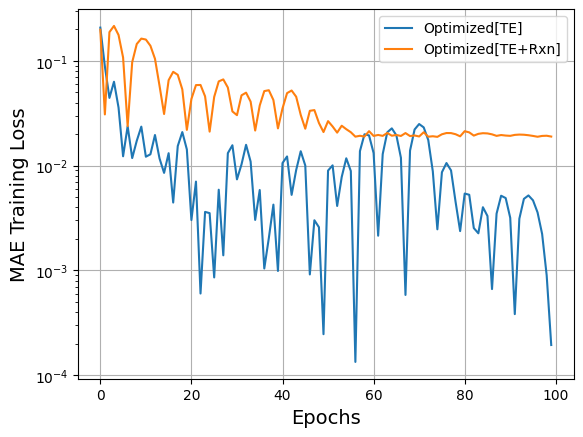

In [53]:
plt.plot(osnmxcl, label='Optimized[TE]')
plt.plot(osnmxcl_rxn, label='Optimized[TE+Rxn]')
# plt.plot(osnmxcl_rxn_10, label='Optimized[TE+10*Rxn]')
# plt.plot(osnmxcl_rxn_only, label='Optimized[Rxn]')
plt.yscale('log')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('MAE Training Loss', fontsize=14)
plt.grid()
plt.legend()

In [95]:
or_ens = {k: 0 for k in relevant_systems}
or10_ens = {k: 0 for k in relevant_systems}
oro_ens = {k: 0 for k in relevant_systems}

In [99]:
for idx, sys in enumerate(relevant_systems):
    atstr = ''
    print(20*'=')
    print(sys)
    for idx, at in enumerate(w27systems[sys]['atoms']):
        atstr += '{} {} {} {}\n'.format(at, *w27systems[sys]['coords'][idx])
    mol = gto_ad.Mole(atom = atstr, charge = w27systems[sys]['charge'], spin = w27systems[sys]['spin'])
    mol.build()
    mol.max_memory = 32000
    #baseline PBE calculation
    print(10*'-')
    print('Optimized+reaction calculation...')
    or_net_eval_xc = partial(eval_xc_gga_j2, xcmodel=osnmxc_rxn)
    mf_or = dft_ad.RKS(mol)
    mf_or.define_xc_(or_net_eval_xc, 'GGA')
    mf_or.grids.level = 1
    mf_or.kernel()
    or_ens[sys] = (mf_or.e_tot, mf_or.converged)
    print(10*'-')


H2O
----------
Optimized+reaction calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
----------
H2O2
----------
Optimized+reaction calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
----------
H2O3
----------
Optimized+reaction calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
----------
H2O4
----------
Optimized+reaction calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
----------
H2O5
----------
Optimized+reaction calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
----------
H2O6
----------
Optimized+reaction calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
----------
OHm
----------
Optimized+reaction calculation...
(7688, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
----------
H3Op
----------
Optimized+reaction calculation...
(12656, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
----------


In [96]:
for idx, sys in enumerate(relevant_systems):
    atstr = ''
    print(20*'=')
    print(sys)
    for idx, at in enumerate(w27systems[sys]['atoms']):
        atstr += '{} {} {} {}\n'.format(at, *w27systems[sys]['coords'][idx])
    mol = gto_ad.Mole(atom = atstr, charge = w27systems[sys]['charge'], spin = w27systems[sys]['spin'])
    mol.build()
    mol.max_memory = 32000
    print('Optimized+10reaction calculation...')
    or10_net_eval_xc = partial(eval_xc_gga_j2, xcmodel=osnmxc_rxn_10)
    mf_or10 = dft_ad.RKS(mol)
    mf_or10.define_xc_(or10_net_eval_xc, 'GGA')
    mf_or10.grids.level = 1
    mf_or10.kernel()
    or10_ens[sys] = (mf_or10.e_tot, mf_or10.converged)
    print(10*'-')
    print('Reaction only calculation...')
    oro_net_eval_xc = partial(eval_xc_gga_j2, xcmodel=osnmxc_rxn_only)
    mf_oro = dft_ad.RKS(mol)
    mf_oro.define_xc_(oro_net_eval_xc, 'GGA')
    mf_oro.grids.level = 1
    mf_oro.kernel()
    oro_ens[sys] = (mf_oro.e_tot, mf_oro.converged)
    print(20*'=')

H2O
Optimized+10reaction calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
----------
Reaction only calculation...
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
(8855, 2)
v2 shape (8855, 2, 2)
H2O2
Optimized+10reaction calculation...
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
----------
Reaction only calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
(17673, 2)
v2 shape (17673, 2, 2)
H2O3
Optimized+10reaction calculation...
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
----------
Reaction only calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
(26160, 2)
v2 shape (26160, 2, 2)
H2O4
Optimized+10reaction calculation...
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
----------
Reaction only calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
(34736, 2)
v2 shape (34736, 2, 2)
H2O5
Optimized+10reaction calculation...
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
----------
Reaction only calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
(43498, 2)
v2 shape (43498, 2, 2)
H2O6
Optimized+10reaction calculation...
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
----------
Reaction only calculation...


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
(51314, 2)
v2 shape (51314, 2, 2)
OHm
Optimized+10reaction calculation...
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
----------
Reaction only calculation...
(7688, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
(7688, 2)
v2 shape (7688, 2, 2)
H3Op
Optimized+10reaction calculation...
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
----------
Reaction only calculation...
(12656, 2)


/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/ICN2/snavarro/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)
(12656, 2)
v2 shape (12656, 2, 2)


In [100]:
path_save_ens = 'energies_ref_and_errors'
np.save(f'{path_save_ens}/or_ens.npy', or_ens)
np.save(f'{path_save_ens}/or10_ens.npy', or10_ens)
np.save(f'{path_save_ens}/oro_ens.npy', oro_ens)

In [ ]:
path_save_ens = 'energies_ref_and_errors'
or_ens = np.load(f'{path_save_ens}/or_ens.npy',allow_pickle='TRUE').item()
or10_ens = np.load(f'{path_save_ens}/or10_ens.npy',allow_pickle='TRUE').item()
oro_ens = np.load(f'{path_save_ens}/oro_ens.npy',allow_pickle='TRUE').item()

In [ ]:
# Saving models
from typing import Union
import json
from xcquinox.net import load_xcquinox_model
def save_eqx_XC_model(model, path: str = '', fixing: Union[str, None] = None,
                   tail_info: Union[str, None] = None):
    if fixing is None:
        fixing = ''
    else:
        fixing = f'_{fixing}'
    if tail_info is None:
        tail_info = ''
    else:
        tail_info = f'_{tail_info}'
    model_x = model.xnet
    save_name_x = f'{model_x.name}_d{model_x.depth}_n{model_x.nodes}_s{model_x.seed}\
{fixing}{tail_info}'

    needen_info_x = {'depth': model_x.depth, 'nodes': model_x.nodes,
                   'seed': model_x.seed, 'name': model_x.name}
    eqx.tree_serialise_leaves(f'{path}/{save_name_x}.eqx', model_x)
    with open(f"{path}/{save_name_x}.json", "w") as f:
        json.dump(needen_info_x, f)
    model_c = model.cnet
    save_name_c = f'{model_c.name}_d{model_c.depth}_n{model_c.nodes}_s{model_c.seed}\
{fixing}{tail_info}'
    needen_info_c = {'depth': model_c.depth, 'nodes': model_c.nodes,
                   'seed': model_c.seed, 'name': model_c.name}
    eqx.tree_serialise_leaves(f'{path}/{save_name_c}.eqx', model_c)
    with open(f"{path}/{save_name_c}.json", "w") as f:
        json.dump(needen_info_c, f)
    needen_info = {'xnet': save_name_x, 'cnet': save_name_c}
    save_name_xc = f'model_xc{fixing}{tail_info}'
    with open(f"{path}/{save_name_xc}.json", "w") as f:
        json.dump(needen_info, f)

def load_eqx_XC_model(model_xc_path):
    
    with open(f"{model_xc_path}.json", "r") as f:
        metadata = json.load(f)
    path = model_xc_path.split('/')
    path = '/'.join(path[:-1])
    model_x = load_xcquinox_model(f'{path}/{metadata["xnet"]}')
    model_c = load_xcquinox_model(f'{path}/{metadata["cnet"]}')
    model = RXCModel(model_x, model_c)
    return model

In [85]:
save_eqx_XC_model(osnmxc_rxn, path='trained_XC', tail_info='osnmxc_rxn')  # Only H2O and H2O2 and reaction - or_err obtained with this
save_eqx_XC_model(osnmxc, path='trained_XC', tail_info='osnmxc') # Optimised with all water27
save_eqx_XC_model(osnmxc_rxn_10, path='trained_XC', tail_info='osnmxc_rxn_10')  # Only H2O and H2O2 and 10*reaction - or10_err obtained with this 
save_eqx_XC_model(osnmxc_rxn_only, path='trained_XC', tail_info='osnmxc_rxn_only') # Only reaction - oro_err obtained with this


In [88]:
osnmxc_rxn = load_eqx_XC_model('trained_XC/model_xc_osnmxc_rxn')
osnmxc = load_eqx_XC_model('trained_XC/model_xc_osnmxc')
osnmxc_rxn_10 = load_eqx_XC_model('trained_XC/model_xc_osnmxc_rxn_10')
osnmxc_rxn_only = load_eqx_XC_model('trained_XC/model_xc_osnmxc_rxn_only')

Loaded trained_XC/GGA_FxNet_sigma_d3_n16_s92017_osnmxc_rxn.eqx
Loaded trained_XC/GGA_FcNet_sigma_d3_n16_s92017_osnmxc_rxn.eqx
Loaded trained_XC/GGA_FxNet_sigma_d3_n16_s92017_osnmxc.eqx
Loaded trained_XC/GGA_FcNet_sigma_d3_n16_s92017_osnmxc.eqx
Loaded trained_XC/GGA_FxNet_sigma_d3_n16_s92017_osnmxc_rxn_10.eqx
Loaded trained_XC/GGA_FcNet_sigma_d3_n16_s92017_osnmxc_rxn_10.eqx
Loaded trained_XC/GGA_FxNet_sigma_d3_n16_s92017_osnmxc_rxn_only.eqx
Loaded trained_XC/GGA_FcNet_sigma_d3_n16_s92017_osnmxc_rxn_only.eqx


In [62]:
def set_latex_font():
    plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['cm'],
    'text.usetex': True,
    'mathtext.fontset': 'cm',
    })

In [63]:
set_latex_font()

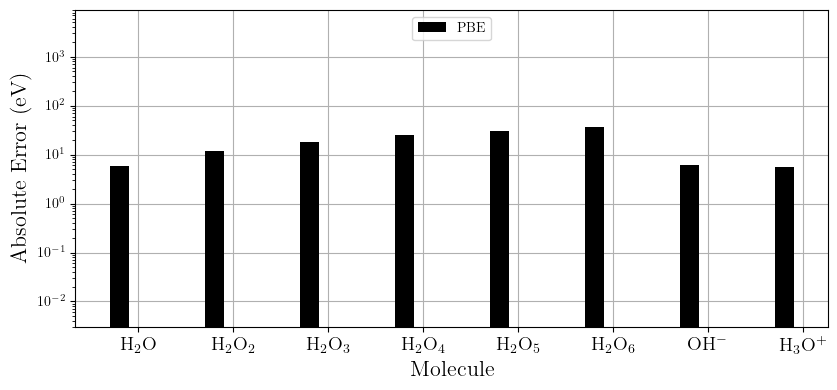

In [ ]:
f = plt.figure(figsize=(8.5,4))
ax = f.add_subplot(111)
relevant_system_ticklabels = ['H$_2$O', 'H$_2$O$_2$', 'H$_2$O$_3$', 'H$_2$O$_4$', 'H$_2$O$_5$', 'H$_2$O$_6$', 'OH$^-$', 'H$_3$O$^+$']

ax.set_xticks(np.arange(1, len(relevant_systems)+2), labels=relevant_system_ticklabels+[''], fontsize=14)
Energy_conv =  27.211386246
# Morado claro  #D4C5E2
# Morado medio  #B669D1
# Verde claro  #C2E2D2 
# Verde medio #5DD69A
# Verde oscuro #3b9078
for idx, sys in enumerate(relevant_systems):
    pbe_err = abs(cc_ens[sys] - pbe_ens[sys][0])*Energy_conv
    ran_err = abs(cc_ens[sys]-ran_ens[sys][0])*Energy_conv
    ranu_err = abs(cc_ens[sys]-ran_unc_ens[sys][0])*Energy_conv
    pre_err = abs(cc_ens[sys]-pre_ens[sys][0])*Energy_conv
    opt_err = abs(cc_ens[sys]-opt_ens[sys][0])*Energy_conv
    or_err = abs(cc_ens[sys] - or_ens[sys][0])*Energy_conv
    # or10_err = abs(cc_ens[sys] - or10_ens[sys][0])*Energy_conv
    # oro_err = abs(cc_ens[sys] - oro_ens[sys][0])*Energy_conv
    if idx == 0:
        ax.bar( (idx+1)-0.2, pbe_err, facecolor='k', width=0.2, label = 'PBE')
        # ax.bar( (idx+1)-0.1, ranu_err, facecolor='#D4C5E2', width=0.2, label = 'Random Weights')
        # ax.bar( (idx+1), ran_err, facecolor='#B669D1', width=0.2, label = 'Random Weights\nw/Constraints')
        # ax.bar( (idx+1)+0.1, pre_err, facecolor='#3b9078', width=0.2, label='Pre-trained\nw/Constraints')
        # ax.bar( (idx+1)+0.2, opt_err, facecolor='#5DD69A', width=0.2, label='Optimized')
        # ax.bar( (idx+1)+0.2, or_err, facecolor='#5DD69A', width=0.2, label='Optimized')
        # ax.bar( (idx+1)+0.2, or10_err, facecolor='c', width=0.2, label='Optimized[TE+10*Rxn]')
        # ax.bar( (idx+1)+0.3, oro_err, facecolor='purple', width=0.2, label='Optimized[Rxn]')
    else: 
        ax.bar( (idx+1)-0.2, pbe_err, facecolor='k', width=0.2)
        # ax.bar( (idx+1)-0.1, ranu_err, facecolor='#D4C5E2', width=0.2)
        # ax.bar( (idx+1)-0.0, ran_err, facecolor='#B669D1', width=0.2)
        # ax.bar( (idx+1)+0.1, pre_err, facecolor='#3b9078', width=0.2)
        # ax.bar( (idx+1)+0.2, opt_err, facecolor='#5DD69A', width=0.2)
        # ax.bar( (idx+1)+0.2, or_err, facecolor='#5DD69A', width=0.2)
        # ax.bar( (idx+1)+0.2, or10_err, facecolor='c', width=0.2)
        # ax.bar( (idx+1)+0.3, oro_err, facecolor='purple', width=0.2)
ax.set_axisbelow(True)
ax.grid()
ax.legend(ncol = 5, loc='upper center')
ax.set_yscale('log')
ax.set_ylim(3e-3, 9e3)
ax.set_xlabel('Molecule', fontsize=16)
ax.set_ylabel('Absolute Error (eV)', fontsize=16)
plt.tight_layout()
plt.savefig('Plot_pbe1.png', dpi=300)
plt.show()
# ax.set_title('Total Energy Prediction Errors\n w.r.t. CCSD in PySCF', fontsize=16)

In [57]:
pbe_ens, ran_unc_ens, ran_ens, pre_ens, opt_ens, or_ens

({'H2O': (Array(-75.22611181, dtype=float64), True),
  'H2O2': (Array(-150.46887406, dtype=float64), True),
  'H2O3': (Array(-225.73216595, dtype=float64), True),
  'H2O4': (Array(-301.01601684, dtype=float64), True),
  'H2O5': (Array(-376.27979653, dtype=float64), True),
  'H2O6': (Array(-451.52503973, dtype=float64), True),
  'OHm': (Array(-74.30269112, dtype=float64), True),
  'H3Op': (Array(-75.59663009, dtype=float64), True)},
 {'H2O': (Array(-71.28800225, dtype=float64), True),
  'H2O2': (Array(-142.59319111, dtype=float64), True),
  'H2O3': (Array(-213.92409675, dtype=float64), True),
  'H2O4': (Array(-285.27318907, dtype=float64), True),
  'H2O5': (Array(-356.59110728, dtype=float64), True),
  'H2O6': (Array(-427.92050759, dtype=float64), True),
  'OHm': (Array(-70.13890395, dtype=float64), True),
  'H3Op': (Array(-71.74983806, dtype=float64), True)},
 {'H2O': (Array(-74.79361605, dtype=float64), True),
  'H2O2': (Array(-149.606992, dtype=float64), True),
  'H2O3': (Array(-224.

Finding errors for -1H2O2 + 2H2O with reference 0.007926693227091634
Finding errors for -1H2O3 + 3H2O with reference 0.025032669322709162
Finding errors for -1H2O4 + 4H2O with reference 0.043590438247011955
Finding errors for -1H2O5 + 5H2O with reference 0.057177689243027886
Finding errors for -1H2O6 + 6H2O with reference 0.07328764940239044


Text(0.5, 1.0, 'Reaction Energy Prediction Errors\n w.r.t. WATER27 Reference Values')

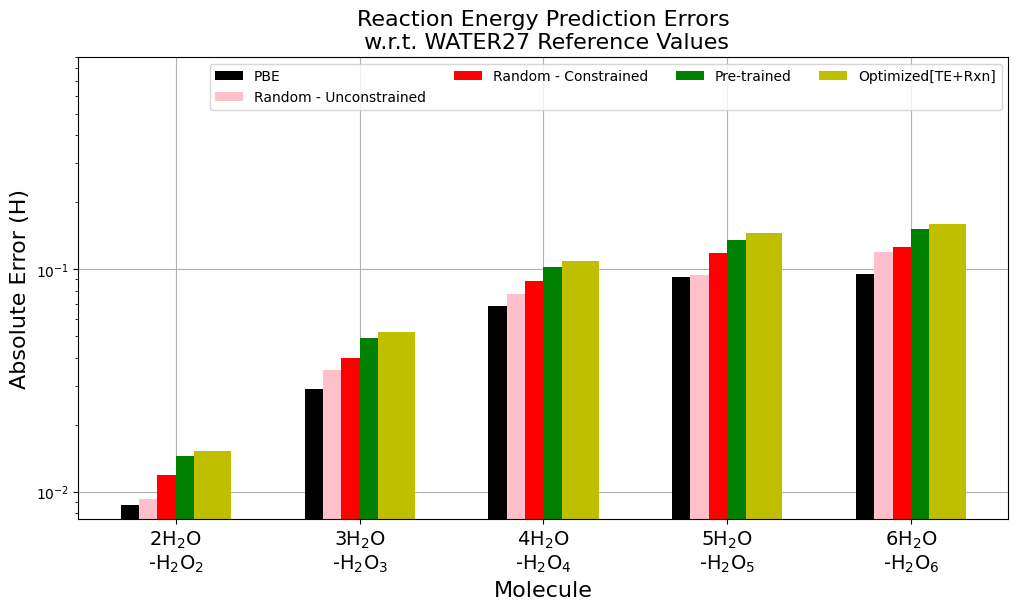

In [58]:
f = plt.figure(figsize=(12,6))
ax = f.add_subplot(111)
relevant_rxn_ticklabels = ['2H$_2$O\n-H$_2$O$_2$', '3H$_2$O\n-H$_2$O$_3$',
                           '4H$_2$O\n-H$_2$O$_4$', '5H$_2$O\n-H$_2$O$_5$',
                           '6H$_2$O\n-H$_2$O$_6$',]
ax.set_xticks(np.arange(1, len(relevant_reactions)+2), labels=relevant_rxn_ticklabels+[''], fontsize=14)

for idx, rxn in enumerate(relevant_reactions):
    sys1, h2o = rxn['systems']
    sys1mult, h2omult = rxn['stoichiometry']
    rxn_ref = rxn['reference']/627.5
    print('Finding errors for {}{} + {}{} with reference {}'.format(sys1mult,sys1,h2omult,h2o,rxn_ref))
    pbe_h = pbe_ens[sys1][0]*sys1mult + pbe_ens[h2o][0]*h2omult
    ran_h = ran_ens[sys1][0]*sys1mult + ran_ens[h2o][0]*h2omult
    ranu_h = ran_unc_ens[sys1][0]*sys1mult + ran_unc_ens[h2o][0]*h2omult
    pre_h = pre_ens[sys1][0]*sys1mult + pre_ens[h2o][0]*h2omult
    opt_h = opt_ens[sys1][0]*sys1mult + opt_ens[h2o][0]*h2omult
    or_h = or_ens[sys1][0]*sys1mult + or_ens[h2o][0]*h2omult
    # or10_h = or10_ens[sys1][0]*sys1mult + or10_ens[h2o][0]*h2omult
    # oro_h = oro_ens[sys1][0]*sys1mult + oro_ens[h2o][0]*h2omult
    # print('Barriers: ', pbe_h, ran_h, pre_h, opt_h, or_h,or10_h,oro_h)
    pbe_err = abs(pbe_h - rxn_ref)
    ran_err = abs(ran_h - rxn_ref)
    ranu_err = abs(ranu_h - rxn_ref)
    pre_err = abs(pre_h - rxn_ref)
    opt_err = abs(opt_h - rxn_ref)
    or_err = abs(or_h - rxn_ref)
    # or10_err = abs(or10_h - rxn_ref)
    # oro_err = abs(oro_h - rxn_ref)
    # print('Errors: ', pbe_err, ran_err, ranu_err, pre_err, opt_err, or_err, or10_err, oro_err)
    if idx == 0:
        ax.bar( (idx+1)-0.2, pbe_err, facecolor='k', width=0.2, label = 'PBE')
        ax.bar( (idx+1)-0.1, ranu_err, facecolor='pink', width=0.2, label='Random - Unconstrained')
        ax.bar( (idx+1), ran_err, facecolor='r', width=0.2, label='Random - Constrained')
        ax.bar( (idx+1)+0.1, pre_err, facecolor='g', width=0.2, label='Pre-trained')
        # ax.bar( (idx+1)+0.05, opt_err, facecolor='b', width=0.2, label='Optimized[TE]')
        ax.bar( (idx+1)+0.2, or_err, facecolor='y', width=0.2, label='Optimized[TE+Rxn]')
        # ax.bar( (idx+1)+0.2, or10_err, facecolor='c', width=0.2, label='Optimized[TE+10*Rxn]')
        # ax.bar( (idx+1)+0.3, oro_err, facecolor='purple', width=0.2, label='Optimized[Rxn]')
    else:
        ax.bar( (idx+1)-0.2, pbe_err, facecolor='k', width=0.2)
        ax.bar( (idx+1)-0.1, ranu_err, facecolor='pink', width=0.2)
        ax.bar( (idx+1), ran_err, facecolor='r', width=0.2)
        ax.bar( (idx+1)+0.1, pre_err, facecolor='g', width=0.2)
        # ax.bar( (idx+1)+0.05, opt_err, facecolor='b', width=0.2)
        ax.bar( (idx+1)+0.2, or_err, facecolor='y', width=0.2)
        # ax.bar( (idx+1)+0.2, or10_err, facecolor='c', width=0.2)
        # ax.bar( (idx+1)+0.3, oro_err, facecolor='purple', width=0.2)
ax.set_axisbelow(True)
ax.grid()
ax.legend(ncol=4)
ax.set_xlabel('Molecule', fontsize=16)
ax.set_ylabel('Absolute Error (H)', fontsize=16)
ax.set_yscale('log')
ax.set_ylim(None, 9e-1)
ax.set_title('Reaction Energy Prediction Errors\n w.r.t. WATER27 Reference Values', fontsize=16)

Text(0, 0.5, 'Learning Rate')

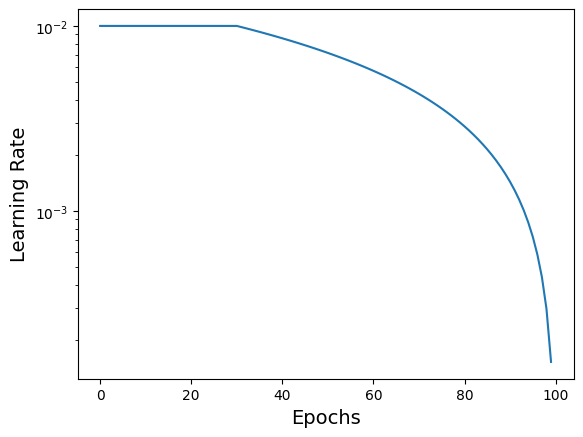

In [59]:
plt.plot(scheduler(np.arange(0, 100)))
plt.yscale('log')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Learning Rate', fontsize=14)

In [60]:
scheduler(np.arange(0, 100))

Array([0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.00985729, 0.00971457, 0.00957186, 0.00942914,
       0.00928643, 0.00914371, 0.009001  , 0.00885829, 0.00871557,
       0.00857286, 0.00843014, 0.00828743, 0.00814471, 0.008002  ,
       0.00785929, 0.00771657, 0.00757386, 0.00743114, 0.00728843,
       0.00714571, 0.007003  , 0.00686029, 0.00671757, 0.00657486,
       0.00643214, 0.00628943, 0.00614671, 0.006004  , 0.00586129,
       0.00571857, 0.00557586, 0.00543314, 0.00529043, 0.00514771,
       0.005005  , 0.00486229, 0.00471957, 0.00457686, 0.00443414,
       0.00429143, 0.00414871, 0.004006  , 0.00386329, 0.00372

In [61]:
1e-4

0.0001